# Configuraciones previas

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy("mixed_float16")

# Utils


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from typing import Tuple, Any, Dict, List
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


def factorize(df: pd.DataFrame, columns: List = None) -> pd.DataFrame:
    if columns is None:
        for column in df.columns:
            if df[column].dtype not in ["int64","float64"]:
                df[column] = df[column].factorize()[0]
    else:
        for column in columns:
            df[column] = df[column].factorize()[0]
    return df

def eliminate_column_na(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    threshold = threshold / 100
    threshold = threshold * len(df)
    df = df.dropna(axis=1, thresh=int(threshold))
    return df

def eliminate_row_na(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    threshold = 100 - threshold
    threshold = threshold / 100
    threshold = threshold * len(df.columns)
    df = df.dropna(axis=0, thresh=int(threshold))
    return df

def split_dataset(df: pd.DataFrame,target_column: str) -> tuple[pd.DataFrame,pd.DataFrame]:
    target_df = df[target_column]
    features_df = df.drop(columns=[target_column])
    return features_df,target_df

def join_dataframe_columns(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    return df1.join(df2)

def join_dataframe_rows(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df1, df2], ignore_index=True)

def read_csv_file(file) -> pd.DataFrame:
    try:
        return pd.read_csv(file)
    except FileNotFoundError:
        raise FileNotFoundError("Archivo no encontrado")
    except:
        raise ValueError("Error en la lectura del archivo")

def write_csv_file(df: pd.DataFrame, nombre_archivo: str = None, ruta: str = None):
    if nombre_archivo is None:
        raise TypeError("Nombre de archivo no especificado")
    if ruta is None:
        df.to_csv(nombre_archivo, index = False)
        return
    df.to_csv(f"{ruta}/{nombre_archivo}")

def train_test_validation_split(df: pd.DataFrame, target_column: str, test_size: float = 0.1, validation_size: float = 0.1) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X, y = split_dataset(df, target_column)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size + validation_size, random_state=19)
    validation_size_proportioned = validation_size / (test_size + validation_size)
    X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=validation_size_proportioned, random_state=19)

    return X_train, y_train, X_test, y_test, X_validation, y_validation
def model_best_parameters(model: Any, scoring: str = "recall", param_distributions: Dict = None ):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=100,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    return random_search
def create_visualize_confusion_matrix(y_true: Any, y_pred: Any) -> None:
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
def create_visualize_classification_report(y_true: Any,y_pred: Any) -> None:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    plt.figure(figsize=(8, 4))
    sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap='Blues')
    plt.title('Classification Report Heatmap')
    plt.show()



# Limpieza Corazon


In [ ]:
def clean_heart(df):
    map_edades = {
        "18-24": 21,
        "25-29": 27,
        "30-34": 32,
        "35-39": 37,
        "40-44": 42,
        "45-49": 47,
        "50-54": 52,
        "55-59": 57,
        "60-64": 62,
        "65-69": 67,
        "70-74": 72,
        "75-79": 77,
        "80 or older": 85
    }
    map_diabetes = {
        "No": 0,
        "No, borderline diabetes": 1,
        "Yes (during pregnancy)": 2,
        "Yes": 3
    }
    map_genhealth = {
        "Excellent": 5,
        "Very good": 4,
        "Good": 3,
        "Fair": 2,
        "Poor": 1
    }
    map_yes_no = {
        "Yes": 1,
        "No": 0
    }
    columns = ["Sex", "Race"]
    df = eliminate_column_na(df, 30)
    df = eliminate_row_na(df, 20)
    df["AgeCategory"] = df["AgeCategory"].map(map_edades)
    df["Diabetic"] = df["Diabetic"].map(map_diabetes)
    df["GenHealth"] = df["GenHealth"].map(map_genhealth)
    df["Smoking"] = df["Smoking"].map(map_yes_no)
    df["AlcoholDrinking"] = df["AlcoholDrinking"].map(map_yes_no)
    df["HeartDisease"] = df["HeartDisease"].map(map_yes_no)
    df["Stroke"] = df["Stroke"].map(map_yes_no)
    df["SkinCancer"] = df["SkinCancer"].map(map_yes_no)
    df["KidneyDisease"] = df["KidneyDisease"].map(map_yes_no)
    df["Asthma"] = df["Asthma"].map(map_yes_no)
    df["DiffWalking"] = df["DiffWalking"].map(map_yes_no)
    df["PhysicalActivity"] = df["PhysicalActivity"].map(map_yes_no)
    df = factorize(df, columns)
    return df




# Limpieza Stroke

In [ ]:
def clean_stroke(df):
    smoke_map = {
    "never smoked": 0,
    "formerly smoked": 1,
    "smokes": 2,
    "Unknown": -1
    }
    married_map = {
        "Yes": 1,
        "No": 0
    }

    df = df.drop("id", axis = 1)
    df["bmi"] = df["bmi"].fillna(df["bmi"].median())
    df["ever_married"] = df["ever_married"].map(married_map)
    df["smoking_status"] = df["smoking_status"].map(smoke_map)
    df = factorize(df, ["gender", "Residence_type","work_type"])
    return df

## Técnicas Precisión


In [ ]:
def SMOTE_technique(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=50)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, y_train
def under_sampling_technique(X_train, y_train):
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=50)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    return X_resampled, y_resampled
def over_sampling_technique(X_train, y_train):
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=50)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train
def smoteen_technique(X_train, y_train):
    from imblearn.combine import SMOTEENN
    smote_enn = SMOTEENN(random_state=50)
    X_train, y_train = smote_enn.fit_resample(X_train, y_train)
    return X_train, y_train
def smotetomek_technique(X_train, y_train):
    from imblearn.combine import SMOTETomek
    smote_tomek = SMOTETomek(random_state=50)
    X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
    return X_train, y_train
def tomek_links_technique(X_train, y_train):
    from imblearn.under_sampling import TomekLinks
    tomek = TomekLinks(sampling_strategy='auto')
    X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)
    return X_resampled, y_resampled
def tomek_links_smote_technique(X_train, y_train):
    from imblearn.combine import SMOTETomek
    smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=50)
    X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
    return X_train, y_train
def nothing(X_train, y_train):
    return X_train, y_train
lista_funciones = [under_sampling_technique, over_sampling_technique, SMOTE_technique, tomek_links_technique, tomek_links_smote_technique,nothing]

# Stroke Normal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC


df = pd.read_csv("Stroke.csv")
df = clean_stroke(df)

X = df.drop("stroke", axis=1)
y = df["stroke"]



cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_encoded = preprocessor.fit_transform(X)



X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)
for funcion in lista_funciones:
  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)


  X_train, y_train = funcion(X_train, y_train)



  weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
  class_weights = dict(zip(np.unique(y_train), weights))



  input_dim = X_train.shape[1]
  model = Sequential([
      Dense(64, input_shape=(input_dim,), kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(32, kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer='adam',
      loss="binary_crossentropy",
      metrics=[Precision(), Recall(), AUC()]
  )

  early_stop = EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)

  model.fit(
      X_train, y_train,
      validation_split=0.1,
      epochs=100,
      batch_size=32,
      class_weight={0: 1, 1: 1},
      callbacks=[early_stop],
      verbose=1
  )



  y_proba = model.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
  f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
  best_threshold = thresholds[np.argmax(f1_scores)]
  y_pred = (y_proba >= best_threshold).astype(int)
  print(funcion.__name__)


  print("Best threshold:", round(best_threshold, 3))
  print("Accuracy:", round(np.mean(y_pred.flatten() == y_test.values), 4))
  print("Precision:", round(precision_score(y_test, y_pred), 4))
  print("Recall:", round(recall_score(y_test, y_pred), 4))
  print("F1-score:", round(f1_score(y_test, y_pred), 4))
  print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - auc_1: 0.5975 - loss: 0.7186 - precision_1: 0.4749 - recall_1: 0.4837 - val_auc_1: 0.0000e+00 - val_loss: 0.5736 - val_precision_1: 1.0000 - val_recall_1: 0.8000
Epoch 2/100
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc_1: 0.6790 - loss: 0.6431 - precision_1: 0.5429 - recall_1: 0.4843 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_1,loss,precision_1,recall_1,val_auc_1,val_loss,val_precision_1,val_recall_1
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc_1: 0.6899 - loss: 0.6333 - precision_1: 0.5636 - recall_1: 0.5065 - val_auc_1: 0.0000e+00 - val_loss: 0.5259 - val_precision_1: 1.0000 - val_recall_1: 0.8444
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc_1: 0.7921 - loss: 0.5583 - precision_1: 0.6980 - recall_1: 0.6395 - val_auc_1: 0.0000e+00 - val_loss: 0.5004 - val_precision_1: 1.0000 - val_recall_1: 0.8444
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc_1: 0.8293 - loss: 0.5260 - precision_1: 0.7258 - recall_1: 0.7594 - val_auc_1: 0.0000e+00 - val_loss: 0.4948 - val_precision_1: 1.0000 - val_recall_1: 0.8667
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc_1: 0.8493 - loss: 0.5167 - precision_1: 0.7330 - recall_1: 0.7610 - val_auc_1: 0.0000e+00 - val_loss: 0.4942 - val_precision_1: 1.0000 - val_recall_1: 0.8222
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc_1: 0.8125 - loss: 0.5474 - precision_1: 0.7164 - recall_1: 0.6780 - val_auc_1: 0.0000e+00 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - auc_2: 0.7378 - loss: 0.6034 - precision_2: 0.6316 - recall_2: 0.6291 - val_auc_2: 0.0000e+00 - val_loss: 0.5095 - val_precision_2: 1.0000 - val_recall_2: 0.8217
Epoch 2/100
 37/247 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.7986 - loss: 0.5294 - precision_2: 0.6784 - recall_2: 0.7647

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_2,loss,precision_2,recall_2,val_auc_2,val_loss,val_precision_2,val_recall_2
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_2: 0.8291 - loss: 0.4998 - precision_2: 0.7043 - recall_2: 0.7815 - val_auc_2: 0.0000e+00 - val_loss: 0.4583 - val_precision_2: 1.0000 - val_recall_2: 0.8297
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_2: 0.8500 - loss: 0.4726 - precision_2: 0.7161 - recall_2: 0.8069 - val_auc_2: 0.0000e+00 - val_loss: 0.4651 - val_precision_2: 1.0000 - val_recall_2: 0.8331
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_2: 0.8486 - loss: 0.4750 - precision_2: 0.7185 - recall_2: 0.8047 - val_auc_2: 0.0000e+00 - val_loss: 0.4473 - val_precision_2: 1.0000 - val_recall_2: 0.8594
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_2: 0.8503 - loss: 0.4707 - precision_2: 0.7114 - recall_2: 0.8203 - val_auc_2: 0.0000e+00 - val_loss: 0.4462 - val_precision_2: 1.0000 - val_recall_2: 0.8560
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_2: 0.8624 - loss: 0.4515 - precision_2: 0.7236 - recall_2: 0.8284 - val_auc_2: 0.0000

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc_3: 0.6911 - loss: 0.6403 - precision_3: 0.5912 - recall_3: 0.6188 - val_auc_3: 0.0000e+00 - val_loss: 0.4962 - val_precision_3: 1.0000 - val_recall_3: 0.8457
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_3,loss,precision_3,recall_3,val_auc_3,val_loss,val_precision_3,val_recall_3
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc_3: 0.8544 - loss: 0.4674 - precision_3: 0.7320 - recall_3: 0.8153 - val_auc_3: 0.0000e+00 - val_loss: 0.4109 - val_precision_3: 1.0000 - val_recall_3: 0.8743
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc_3: 0.8662 - loss: 0.4496 - precision_3: 0.7400 - recall_3: 0.8370 - val_auc_3: 0.0000e+00 - val_loss: 0.3863 - val_precision_3: 1.0000 - val_recall_3: 0.8983
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_3: 0.8709 - loss: 0.4408 - precision_3: 0.7451 - recall_3: 0.8511 - val_auc_3: 0.0000e+00 - val_loss: 0.3726 - val_precision_3: 1.0000 - val_recall_3: 0.9051
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_3: 0.8738 - loss: 0.4341 - precision_3: 0.7429 - recall_3: 0.8571 - val_auc_3: 0.0000e+00 - val_loss: 0.3933 - val_precision_3: 1.0000 - val_recall_3: 0.9017
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_3: 0.8800 - loss: 0.4201 - precision_3: 0.7529 - recall_3: 0.8576 - val_auc_3: 0.0000

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - auc_4: 0.5791 - loss: 0.5651 - precision_4: 0.0739 - recall_4: 0.3643 - val_auc_4: 0.7612 - val_loss: 0.3328 - val_precision_4: 1.0000 - val_recall_4: 0.0435
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_4,loss,precision_4,recall_4,val_auc_4,val_loss,val_precision_4,val_recall_4
  current = self.get_monitor_value(logs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_4: 0.6773 - loss: 0.2515 - precision_4: 0.1933 - recall_4: 0.0613 - val_auc_4: 0.8222 - val_loss: 0.2110 - val_precision_4: 1.0000 - val_recall_4: 0.0435
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_4: 0.7334 - loss: 0.2016 - precision_4: 0.1612 - recall_4: 0.0239 - val_auc_4: 0.8350 - val_loss: 0.1805 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_4: 0.8001 - loss: 0.1794 - precision_4: 0.1383 - recall_4: 0.0086 - val_auc_4: 0.8387 - val_loss: 0.1707 - val_precision_4: 1.0000 - val_recall_4: 0.0435
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_4: 0.7606 - loss: 0.1678 - precision_4: 0.2187 - recall_4: 0.0138 - val_auc_4: 0.8588 - val_loss: 0.1635 - val_precision_4: 1.0000 - val_recall_4: 0.0435
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_4: 0.8080 - loss: 0.1958 - precision_4: 0.2092 - recall_4: 0.0164 - val_auc_4: 0.8508 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - auc_5: 0.7406 - loss: 0.6042 - precision_5: 0.6236 - recall_5: 0.6827 - val_auc_5: 0.0000e+00 - val_loss: 0.4498 - val_precision_5: 1.0000 - val_recall_5: 0.8885
Epoch 2/100
 20/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc_5: 0.8688 - loss: 0.4553 - precision_5: 0.6810 - recall_5: 0.8991

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_5,loss,precision_5,recall_5,val_auc_5,val_loss,val_precision_5,val_recall_5
  current = self.get_monitor_value(logs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc_5: 0.8559 - loss: 0.4632 - precision_5: 0.7235 - recall_5: 0.8445 - val_auc_5: 0.0000e+00 - val_loss: 0.4296 - val_precision_5: 1.0000 - val_recall_5: 0.8897
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_5: 0.8558 - loss: 0.4618 - precision_5: 0.7327 - recall_5: 0.8178 - val_auc_5: 0.0000e+00 - val_loss: 0.3930 - val_precision_5: 1.0000 - val_recall_5: 0.9103
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_5: 0.8765 - loss: 0.4318 - precision_5: 0.7501 - recall_5: 0.8461 - val_auc_5: 0.0000e+00 - val_loss: 0.3885 - val_precision_5: 1.0000 - val_recall_5: 0.9069
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_5: 0.8747 - loss: 0.4319 - precision_5: 0.7480 - recall_5: 0.8483 - val_auc_5: 0.0000e+00 - val_loss: 0.3597 - val_precision_5: 1.0000 - val_recall_5: 0.9034
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_5: 0.8760 - loss: 0.4257 - precision_5: 0.7527 - recall_5: 0.8576 - val_auc_5: 0.0000

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc_6: 0.5517 - loss: 0.4544 - precision_6: 0.0541 - recall_6: 0.1586 - val_auc_6: 0.8044 - val_loss: 0.2630 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/100
 41/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_6: 0.6114 - loss: 0.2259 - precision_6: 0.0821 - recall_6: 0.0120

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_6,loss,precision_6,recall_6,val_auc_6,val_loss,val_precision_6,val_recall_6
  current = self.get_monitor_value(logs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_6: 0.6642 - loss: 0.2160 - precision_6: 0.1235 - recall_6: 0.0128 - val_auc_6: 0.8631 - val_loss: 0.1810 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_6: 0.7413 - loss: 0.1866 - precision_6: 0.0438 - recall_6: 0.0037 - val_auc_6: 0.8456 - val_loss: 0.1685 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_6: 0.7588 - loss: 0.1753 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_auc_6: 0.8476 - val_loss: 0.1652 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_6: 0.8404 - loss: 0.1742 - precision_6: 0.0763 - recall_6: 0.0017 - val_auc_6: 0.8406 - val_loss: 0.1660 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_6: 0.8001 - loss: 0.1748 - precision_6: 0.5158 - recall_6: 0.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.over_sampling import SMOTENC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC



df = pd.read_csv("Stroke.csv")
df = clean_stroke(df)

X = df.drop("stroke", axis=1)
y = df["stroke"]



cat_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type","smoking_status"]
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_indices = [X.columns.get_loc(col) for col in cat_features]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)


smote_nc = SMOTENC(categorical_features=cat_indices, random_state=50)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)



preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_train_encoded = preprocessor.fit_transform(X_train_resampled)
X_test_encoded = preprocessor.transform(X_test)


weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = dict(zip(np.unique(y_train_resampled), weights))

input_dim = X_train_encoded.shape[1]
model = Sequential([
    Dense(64, input_shape=(input_dim,), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    ReLU(negative_slope=0.01),
    Dropout(0.2),
    Dense(32, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    ReLU(negative_slope=0.01),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=[Precision(), Recall(), AUC()]
)

early_stop = EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)

model.fit(
    X_train_encoded, y_train_resampled,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


y_proba = model.predict(X_test_encoded)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_proba >= best_threshold).astype(int)

print("Best threshold:", round(best_threshold, 3))
print("Accuracy:", round(np.mean(y_pred.flatten() == y_test.values), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1-score:", round(f1_score(y_test, y_pred), 4))
print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - auc_2: 0.6910 - loss: 0.6502 - precision_2: 0.5922 - recall_2: 0.6265 - val_auc_2: 0.0000e+00 - val_loss: 0.4307 - val_precision_2: 1.0000 - val_recall_2: 0.8800
Epoch 2/100
 57/247 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_2: 0.8445 - loss: 0.4973 - precision_2: 0.7299 - recall_2: 0.7767

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_2,loss,precision_2,recall_2,val_auc_2,val_loss,val_precision_2,val_recall_2
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_2: 0.8590 - loss: 0.4715 - precision_2: 0.7437 - recall_2: 0.7890 - val_auc_2: 0.0000e+00 - val_loss: 0.3719 - val_precision_2: 1.0000 - val_recall_2: 0.9063
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_2: 0.8745 - loss: 0.4385 - precision_2: 0.7454 - recall_2: 0.8202 - val_auc_2: 0.0000e+00 - val_loss: 0.3820 - val_precision_2: 1.0000 - val_recall_2: 0.8994
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_2: 0.8852 - loss: 0.4196 - precision_2: 0.7537 - recall_2: 0.8463 - val_auc_2: 0.0000e+00 - val_loss: 0.3624 - val_precision_2: 1.0000 - val_recall_2: 0.9074
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_2: 0.8851 - loss: 0.4185 - precision_2: 0.7516 - recall_2: 0.8277 - val_auc_2: 0.0000e+00 - val_loss: 0.3396 - val_precision_2: 1.0000 - val_recall_2: 0.9177
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_2: 0.8918 - loss: 0.4093 - precision_2: 0.7722 - recall_2: 0.8441 - val_auc_2: 0.0000

In [ ]:
print(X.dtypes)

gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
dtype: object


#Enfermedad Bucle

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC

df = pd.read_csv("EnfermedadCorazon.csv")
df = clean_heart(df)

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]


cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_encoded = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)
for funcion in lista_funciones:
  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)

  X_train, y_train = funcion(X_train, y_train)


  weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
  class_weights = dict(zip(np.unique(y_train), weights))


  input_dim = X_train.shape[1]
  model = Sequential([
      Dense(64, input_shape=(input_dim,), kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(32, kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer='adam',
      loss="binary_crossentropy",
      metrics=[Precision(), Recall(), AUC()]
  )

  early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True)

  model.fit(
      X_train, y_train,
      validation_split=0.1,
      epochs=10,
      batch_size=32,
      class_weight={0: 1, 1: 1},
      callbacks=[early_stop],
      verbose=1
  )


  y_proba = model.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
  f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
  best_threshold = thresholds[np.argmax(f1_scores)]
  y_pred = (y_proba >= best_threshold).astype(int)
  print(funcion.__name__)

  print("Best threshold:", round(best_threshold, 3))
  print("Accuracy:", round(np.mean(y_pred.flatten() == y_test.values), 4))
  print("Precision:", round(precision_score(y_test, y_pred), 4))
  print("Recall:", round(recall_score(y_test, y_pred), 4))
  print("F1-score:", round(f1_score(y_test, y_pred), 4))
  print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - auc_8: 0.7876 - loss: 0.5590 - precision_8: 0.6851 - recall_8: 0.6984 - val_auc_8: 0.0000e+00 - val_loss: 0.5727 - val_precision_8: 1.0000 - val_recall_8: 0.7677
Epoch 2/10
   8/1386 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - auc_8: 0.8215 - loss: 0.5058 - precision_8: 0.6224 - recall_8: 0.7661  

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_8,loss,precision_8,recall_8,val_auc_8,val_loss,val_precision_8,val_recall_8
  current = self.get_monitor_value(logs)


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc_8: 0.8241 - loss: 0.5172 - precision_8: 0.7068 - recall_8: 0.7420 - val_auc_8: 0.0000e+00 - val_loss: 0.5676 - val_precision_8: 1.0000 - val_recall_8: 0.7646
Epoch 3/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc_8: 0.8311 - loss: 0.5081 - precision_8: 0.7111 - recall_8: 0.7599 - val_auc_8: 0.0000e+00 - val_loss: 0.5395 - val_precision_8: 1.0000 - val_recall_8: 0.7608
Epoch 4/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - auc_8: 0.8332 - loss: 0.5055 - precision_8: 0.7165 - recall_8: 0.7487 - val_auc_8: 0.0000e+00 - val_loss: 0.5478 - val_precision_8: 1.0000 - val_recall_8: 0.7681
Epoch 5/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc_8: 0.8316 - loss: 0.5071 - precision_8: 0.7124 - recall_8: 0.7524 - val_auc_8: 0.0000e+00 - val_loss: 0.5323 - val_precision_8: 1.0000 - val_recall_8: 0.7758
Epoch 6/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - auc_8: 0.8317 - loss: 0.5066 - precision_8: 0.7136 - recall_8: 0.7533 - val_auc_8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - auc_9: 0.8245 - loss: 0.5166 - precision_9: 0.7093 - recall_9: 0.7409 - val_auc_9: 0.0000e+00 - val_loss: 0.5558 - val_precision_9: 1.0000 - val_recall_9: 0.7685
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_9,loss,precision_9,recall_9,val_auc_9,val_loss,val_precision_9,val_recall_9
  current = self.get_monitor_value(logs)


14804/14804 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - auc_9: 0.8347 - loss: 0.5008 - precision_9: 0.7153 - recall_9: 0.7618 - val_auc_9: 0.0000e+00 - val_loss: 0.5629 - val_precision_9: 1.0000 - val_recall_9: 0.7639
Epoch 3/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - auc_9: 0.8360 - loss: 0.4986 - precision_9: 0.7174 - recall_9: 0.7589 - val_auc_9: 0.0000e+00 - val_loss: 0.5509 - val_precision_9: 1.0000 - val_recall_9: 0.7652
Epoch 4/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - auc_9: 0.8353 - loss: 0.4996 - precision_9: 0.7153 - recall_9: 0.7604 - val_auc_9: 0.0000e+00 - val_loss: 0.5488 - val_precision_9: 1.0000 - val_recall_9: 0.7686
Epoch 5/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - auc_9: 0.8351 - loss: 0.4996 - precision_9: 0.7166 - recall_9: 0.7560 - val_auc_9: 0.0000e+00 - val_loss: 0.5617 - val_precision_9: 1.0000 - val_recall_9: 0.7720
Epoch 6/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - auc_9: 0.8352 - loss: 0.4997 - precision_9: 0.7180 - recall_9: 0.755

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - auc_10: 0.8286 - loss: 0.5152 - precision_10: 0.7054 - recall_10: 0.7625 - val_auc_10: 0.0000e+00 - val_loss: 0.5149 - val_precision_10: 1.0000 - val_recall_10: 0.7783
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_10,loss,precision_10,recall_10,val_auc_10,val_loss,val_precision_10,val_recall_10
  current = self.get_monitor_value(logs)


14804/14804 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - auc_10: 0.8415 - loss: 0.4913 - precision_10: 0.7200 - recall_10: 0.7656 - val_auc_10: 0.0000e+00 - val_loss: 0.5609 - val_precision_10: 1.0000 - val_recall_10: 0.7598
Epoch 3/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - auc_10: 0.8417 - loss: 0.4908 - precision_10: 0.7208 - recall_10: 0.7644 - val_auc_10: 0.0000e+00 - val_loss: 0.5234 - val_precision_10: 1.0000 - val_recall_10: 0.7770
Epoch 4/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - auc_10: 0.8425 - loss: 0.4898 - precision_10: 0.7240 - recall_10: 0.7649 - val_auc_10: 0.0000e+00 - val_loss: 0.5448 - val_precision_10: 1.0000 - val_recall_10: 0.7815
Epoch 5/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - auc_10: 0.8439 - loss: 0.4880 - precision_10: 0.7240 - recall_10: 0.7671 - val_auc_10: 0.0000e+00 - val_loss: 0.4873 - val_precision_10: 1.0000 - val_recall_10: 0.7979
Epoch 6/10
14804/14804 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - auc_10: 0.8421 - loss: 0.4903 - precision_10

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7848/7848 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - auc_11: 0.7829 - loss: 0.2899 - precision_11: 0.3060 - recall_11: 0.1173 - val_auc_11: 0.8517 - val_loss: 0.2286 - val_precision_11: 0.5942 - val_recall_11: 0.0930
Epoch 2/10
  27/7848 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - auc_11: 0.8587 - loss: 0.2545 - precision_11: 0.7998 - recall_11: 0.1106

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_11,loss,precision_11,recall_11,val_auc_11,val_loss,val_precision_11,val_recall_11
  current = self.get_monitor_value(logs)


7848/7848 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - auc_11: 0.8381 - loss: 0.2370 - precision_11: 0.5910 - recall_11: 0.0667 - val_auc_11: 0.8529 - val_loss: 0.2266 - val_precision_11: 0.5958 - val_recall_11: 0.1057
Epoch 3/10
7848/7848 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - auc_11: 0.8404 - loss: 0.2339 - precision_11: 0.5719 - recall_11: 0.0770 - val_auc_11: 0.8533 - val_loss: 0.2257 - val_precision_11: 0.6144 - val_recall_11: 0.0946
Epoch 4/10
7848/7848 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - auc_11: 0.8420 - loss: 0.2338 - precision_11: 0.5798 - recall_11: 0.0907 - val_auc_11: 0.8531 - val_loss: 0.2258 - val_precision_11: 0.6163 - val_recall_11: 0.0651
Epoch 5/10
7848/7848 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - auc_11: 0.8444 - loss: 0.2318 - precision_11: 0.5712 - recall_11: 0.0816 - val_auc_11: 0.8528 - val_loss: 0.2256 - val_precision_11: 0.6072 - val_recall_11: 0.0962
Epoch 6/10
7848/7848 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - auc_11: 0.8435 - loss: 0.2312 - precision_11: 0.5766 - recall_11: 0.08

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14496/14496 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - auc_12: 0.8368 - loss: 0.5007 - precision_12: 0.7195 - recall_12: 0.7569 - val_auc_12: 0.0000e+00 - val_loss: 0.4988 - val_precision_12: 1.0000 - val_recall_12: 0.7950
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_12,loss,precision_12,recall_12,val_auc_12,val_loss,val_precision_12,val_recall_12
  current = self.get_monitor_value(logs)


14496/14496 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - auc_12: 0.8468 - loss: 0.4850 - precision_12: 0.7288 - recall_12: 0.7752 - val_auc_12: 0.0000e+00 - val_loss: 0.5252 - val_precision_12: 1.0000 - val_recall_12: 0.7912
Epoch 3/10
14496/14496 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - auc_12: 0.8478 - loss: 0.4830 - precision_12: 0.7280 - recall_12: 0.7769 - val_auc_12: 0.0000e+00 - val_loss: 0.5365 - val_precision_12: 1.0000 - val_recall_12: 0.7811
Epoch 4/10
14496/14496 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - auc_12: 0.8485 - loss: 0.4822 - precision_12: 0.7292 - recall_12: 0.7733 - val_auc_12: 0.0000e+00 - val_loss: 0.5042 - val_precision_12: 1.0000 - val_recall_12: 0.8004
Epoch 5/10
14496/14496 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - auc_12: 0.8483 - loss: 0.4825 - precision_12: 0.7299 - recall_12: 0.7719 - val_auc_12: 0.0000e+00 - val_loss: 0.4893 - val_precision_12: 1.0000 - val_recall_12: 0.8043
Epoch 6/10
14496/14496 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - auc_12: 0.8499 - loss: 0.4801 - precision_12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8095/8095 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - auc_13: 0.7785 - loss: 0.2758 - precision_13: 0.2766 - recall_13: 0.0707 - val_auc_13: 0.8418 - val_loss: 0.2295 - val_precision_13: 0.5833 - val_recall_13: 0.0287
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_13,loss,precision_13,recall_13,val_auc_13,val_loss,val_precision_13,val_recall_13
  current = self.get_monitor_value(logs)


8095/8095 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - auc_13: 0.8284 - loss: 0.2370 - precision_13: 0.5691 - recall_13: 0.0317 - val_auc_13: 0.8423 - val_loss: 0.2281 - val_precision_13: 0.6187 - val_recall_13: 0.0352
Epoch 3/10
8095/8095 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - auc_13: 0.8326 - loss: 0.2330 - precision_13: 0.5413 - recall_13: 0.0418 - val_auc_13: 0.8424 - val_loss: 0.2268 - val_precision_13: 0.5603 - val_recall_13: 0.0913
Epoch 4/10
8095/8095 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - auc_13: 0.8330 - loss: 0.2344 - precision_13: 0.5497 - recall_13: 0.0495 - val_auc_13: 0.8433 - val_loss: 0.2266 - val_precision_13: 0.5732 - val_recall_13: 0.0737
Epoch 5/10
8095/8095 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - auc_13: 0.8320 - loss: 0.2341 - precision_13: 0.5359 - recall_13: 0.0458 - val_auc_13: 0.8443 - val_loss: 0.2257 - val_precision_13: 0.5567 - val_recall_13: 0.0684
Epoch 6/10
8095/8095 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - auc_13: 0.8329 - loss: 0.2321 - precision_13: 0.5417 - recall_13: 0.04

# SMOTE ANTES DEL SPLIT

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC

df = pd.read_csv("Stroke.csv")
print(df.columns)
df = clean_stroke(df)

X = df.drop("stroke", axis=1)
y = df["stroke"]


cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_encoded = preprocessor.fit_transform(X)

X_encoded, y = SMOTE_technique(X_encoded, y)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)
for funcion in lista_funciones:



  weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
  class_weights = dict(zip(np.unique(y_train), weights))


  input_dim = X_train.shape[1]
  model = Sequential([
      Dense(64, input_shape=(input_dim,), kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(32, kernel_regularizer=l2(0.0001)),
      BatchNormalization(),
      ReLU(negative_slope=0.01),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer='adam',
      loss="binary_crossentropy",
      metrics=[Precision(), Recall(), AUC()]
  )

  early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True)

  model.fit(
      X_train, y_train,
      validation_split=0.1,
      epochs=10,
      batch_size=32,
      class_weight=class_weights,
      callbacks=[early_stop],
      verbose=1
  )


  y_proba = model.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
  f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
  best_threshold = thresholds[np.argmax(f1_scores)]
  y_pred = (y_proba >= best_threshold).astype(int)
  print(funcion.__name__)

  print("Best threshold:", round(best_threshold, 3))
  print("Accuracy:", round(np.mean(y_pred.flatten() == y_test.values), 4))
  print("Precision:", round(precision_score(y_test, y_pred), 4))
  print("Recall:", round(recall_score(y_test, y_pred), 4))
  print("F1-score:", round(f1_score(y_test, y_pred), 4))
  print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - auc_15: 0.7255 - loss: 0.6164 - precision_15: 0.6685 - recall_15: 0.6510 - val_auc_15: 0.8581 - val_loss: 0.4533 - val_precision_15: 0.7475 - val_recall_15: 0.8776
Epoch 2/10
 13/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - auc_15: 0.8139 - loss: 0.5394 - precision_15: 0.7649 - recall_15: 0.7523

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_15,loss,precision_15,recall_15,val_auc_15,val_loss,val_precision_15,val_recall_15
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_15: 0.8486 - loss: 0.4767 - precision_15: 0.7647 - recall_15: 0.8247 - val_auc_15: 0.8738 - val_loss: 0.4212 - val_precision_15: 0.7648 - val_recall_15: 0.8800
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc_15: 0.8599 - loss: 0.4615 - precision_15: 0.7495 - recall_15: 0.8529 - val_auc_15: 0.8803 - val_loss: 0.4156 - val_precision_15: 0.7588 - val_recall_15: 0.9106
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - auc_15: 0.8663 - loss: 0.4465 - precision_15: 0.7622 - recall_15: 0.8649 - val_auc_15: 0.8845 - val_loss: 0.4078 - val_precision_15: 0.7591 - val_recall_15: 0.8824
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - auc_15: 0.8727 - loss: 0.4393 - precision_15: 0.7684 - recall_15: 0.8811 - val_auc_15: 0.8931 - val_loss: 0.3987 - val_precision_15: 0.7602 - val_recall_15: 0.9247
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - auc_15: 0.8694 - loss: 0.4392 - precision_15: 0.7656 - recall_15: 0.8822 - val_auc_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - auc_16: 0.7331 - loss: 0.6538 - precision_16: 0.7137 - recall_16: 0.5256 - val_auc_16: 0.8708 - val_loss: 0.4384 - val_precision_16: 0.7451 - val_recall_16: 0.9012
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_16,loss,precision_16,recall_16,val_auc_16,val_loss,val_precision_16,val_recall_16
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - auc_16: 0.8572 - loss: 0.4668 - precision_16: 0.7593 - recall_16: 0.8512 - val_auc_16: 0.8802 - val_loss: 0.4170 - val_precision_16: 0.7495 - val_recall_16: 0.9082
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_16: 0.8562 - loss: 0.4593 - precision_16: 0.7671 - recall_16: 0.8716 - val_auc_16: 0.8850 - val_loss: 0.4073 - val_precision_16: 0.7520 - val_recall_16: 0.8988
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_16: 0.8702 - loss: 0.4402 - precision_16: 0.7702 - recall_16: 0.8550 - val_auc_16: 0.8869 - val_loss: 0.4071 - val_precision_16: 0.7590 - val_recall_16: 0.9412
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_16: 0.8707 - loss: 0.4367 - precision_16: 0.7677 - recall_16: 0.8758 - val_auc_16: 0.8936 - val_loss: 0.3948 - val_precision_16: 0.7739 - val_recall_16: 0.9341
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_16: 0.8829 - loss: 0.4234 - precision_16: 0.7859 - recall_16: 0.8718 - val_auc_16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc_17: 0.7664 - loss: 0.5850 - precision_17: 0.6849 - recall_17: 0.7678 - val_auc_17: 0.8647 - val_loss: 0.4462 - val_precision_17: 0.7354 - val_recall_17: 0.8894
Epoch 2/10
 41/247 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_17: 0.8704 - loss: 0.4373 - precision_17: 0.7785 - recall_17: 0.8712

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_17,loss,precision_17,recall_17,val_auc_17,val_loss,val_precision_17,val_recall_17
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_17: 0.8473 - loss: 0.4742 - precision_17: 0.7488 - recall_17: 0.8460 - val_auc_17: 0.8740 - val_loss: 0.4253 - val_precision_17: 0.7520 - val_recall_17: 0.8847
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_17: 0.8569 - loss: 0.4628 - precision_17: 0.7513 - recall_17: 0.8656 - val_auc_17: 0.8850 - val_loss: 0.4135 - val_precision_17: 0.7534 - val_recall_17: 0.9129
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc_17: 0.8668 - loss: 0.4465 - precision_17: 0.7618 - recall_17: 0.8781 - val_auc_17: 0.8911 - val_loss: 0.4049 - val_precision_17: 0.7699 - val_recall_17: 0.8894
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_17: 0.8704 - loss: 0.4407 - precision_17: 0.7666 - recall_17: 0.8687 - val_auc_17: 0.8970 - val_loss: 0.3974 - val_precision_17: 0.7594 - val_recall_17: 0.9059
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_17: 0.8690 - loss: 0.4395 - precision_17: 0.7560 - recall_17: 0.8839 - val_auc_17

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc_18: 0.7409 - loss: 0.6048 - precision_18: 0.6509 - recall_18: 0.7846 - val_auc_18: 0.8681 - val_loss: 0.4485 - val_precision_18: 0.7455 - val_recall_18: 0.8682
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_18,loss,precision_18,recall_18,val_auc_18,val_loss,val_precision_18,val_recall_18
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_18: 0.8499 - loss: 0.4792 - precision_18: 0.7615 - recall_18: 0.8280 - val_auc_18: 0.8802 - val_loss: 0.4178 - val_precision_18: 0.7606 - val_recall_18: 0.8824
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_18: 0.8476 - loss: 0.4736 - precision_18: 0.7509 - recall_18: 0.8351 - val_auc_18: 0.8856 - val_loss: 0.4101 - val_precision_18: 0.7570 - val_recall_18: 0.8941
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_18: 0.8694 - loss: 0.4434 - precision_18: 0.7691 - recall_18: 0.8627 - val_auc_18: 0.8908 - val_loss: 0.4012 - val_precision_18: 0.7810 - val_recall_18: 0.8894
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.8680 - loss: 0.4463 - precision_18: 0.7713 - recall_18: 0.8750 - val_auc_18: 0.8927 - val_loss: 0.3976 - val_precision_18: 0.7801 - val_recall_18: 0.8847
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.8727 - loss: 0.4364 - precision_18: 0.7639 - recall_18: 0.8701 - val_auc_18

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc_19: 0.7450 - loss: 0.6038 - precision_19: 0.6651 - recall_19: 0.7451 - val_auc_19: 0.8721 - val_loss: 0.4416 - val_precision_19: 0.7556 - val_recall_19: 0.8800
Epoch 2/10
 38/247 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_19: 0.8578 - loss: 0.4652 - precision_19: 0.7465 - recall_19: 0.8281

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_19,loss,precision_19,recall_19,val_auc_19,val_loss,val_precision_19,val_recall_19
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_19: 0.8473 - loss: 0.4778 - precision_19: 0.7502 - recall_19: 0.8269 - val_auc_19: 0.8776 - val_loss: 0.4228 - val_precision_19: 0.7495 - val_recall_19: 0.8871
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_19: 0.8559 - loss: 0.4618 - precision_19: 0.7633 - recall_19: 0.8471 - val_auc_19: 0.8866 - val_loss: 0.4085 - val_precision_19: 0.7672 - val_recall_19: 0.8682
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc_19: 0.8590 - loss: 0.4577 - precision_19: 0.7541 - recall_19: 0.8607 - val_auc_19: 0.8893 - val_loss: 0.4021 - val_precision_19: 0.7657 - val_recall_19: 0.9153
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_19: 0.8610 - loss: 0.4540 - precision_19: 0.7479 - recall_19: 0.8820 - val_auc_19: 0.8969 - val_loss: 0.3956 - val_precision_19: 0.7676 - val_recall_19: 0.9247
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_19: 0.8796 - loss: 0.4289 - precision_19: 0.7804 - recall_19: 0.8695 - val_auc_19

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - auc_20: 0.7565 - loss: 0.5945 - precision_20: 0.7033 - recall_20: 0.6400 - val_auc_20: 0.8706 - val_loss: 0.4371 - val_precision_20: 0.7470 - val_recall_20: 0.8894
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: auc_20,loss,precision_20,recall_20,val_auc_20,val_loss,val_precision_20,val_recall_20
  current = self.get_monitor_value(logs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc_20: 0.8481 - loss: 0.4763 - precision_20: 0.7470 - recall_20: 0.8346 - val_auc_20: 0.8822 - val_loss: 0.4159 - val_precision_20: 0.7556 - val_recall_20: 0.8800
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_20: 0.8614 - loss: 0.4581 - precision_20: 0.7573 - recall_20: 0.8602 - val_auc_20: 0.8889 - val_loss: 0.4051 - val_precision_20: 0.7621 - val_recall_20: 0.8894
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_20: 0.8647 - loss: 0.4526 - precision_20: 0.7581 - recall_20: 0.8616 - val_auc_20: 0.8885 - val_loss: 0.4039 - val_precision_20: 0.7655 - val_recall_20: 0.8988
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_20: 0.8702 - loss: 0.4378 - precision_20: 0.7671 - recall_20: 0.8617 - val_auc_20: 0.8942 - val_loss: 0.3946 - val_precision_20: 0.7683 - val_recall_20: 0.9129
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_20: 0.8711 - loss: 0.4405 - precision_20: 0.7676 - recall_20: 0.8590 - val_auc_20

# Enfermedad Normal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2
from datetime import datetime
import os
import csv
import itertools
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Nadam, Adam
from sklearn.metrics import precision_recall_curve


DATASET_NAME = "EnfermedadCorazon.csv"
CSV_LOG_PATH = "logs_modelos.csv"


df = pd.read_csv(DATASET_NAME)
df = clean_heart(df)


X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]




X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for funcion in lista_funciones:
  funcion_ = funcion
  X_train, y_train = funcion_(X_train, y_train)
  sampling_technique = funcion.__name__
  threshold = 0.65
  batch_size = 32
  class_weight = {0: 1, 1: 1.2}
  epochs = 5
  header = [
      "sampling_technique","timestamp", "dataset", "threshold", "batch_size", "epochs_trained",
      "epochs_set", "class_weight", "accuracy", "precision", "recall", "f1_score", "auc",
      "confusion_matrix", "model_summary"
  ]
  print(f"\n🔥 threshold={threshold}, batch_size={batch_size}, class_weight={class_weight}, epochs={epochs}")



  input_dim = X_train.shape[1]
  model = Sequential([
      Dense(64, kernel_regularizer=l2(0.0001)),
      LeakyReLU(alpha=0.01),
      Dropout(0.3),
      Dense(32, kernel_regularizer=l2(0.0001)),
      LeakyReLU(alpha=0.01),
      Dropout(0.3),
      Dense(16, kernel_regularizer=l2(0.0001)),
      LeakyReLU(alpha=0.01),
      Dropout(0.3),
      Dense(1, activation='sigmoid')
  ])



  optimizer = Adam(learning_rate=0.0005)
  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
  )

  early_stop = EarlyStopping(monitor='val_recall', patience=10, mode='max', min_delta = 0.02, restore_best_weights=True)



  history = model.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size=batch_size,
      validation_split=0.2,
      callbacks=[early_stop],
      class_weight=class_weight,
      verbose=1
  )



  y_proba = model.predict(X_test)
  y_pred = (y_proba > threshold).astype("int32")

  accuracy = round(np.mean(y_pred.flatten() == y_test.values), 4)
  precision = round(precision_score(y_test, y_pred), 4)
  recall = round(recall_score(y_test, y_pred), 4)
  f1 = round(f1_score(y_test, y_pred), 4)
  auc = round(tf.keras.metrics.AUC()(y_test, y_proba).numpy(), 4)
  conf_matrix = confusion_matrix(y_test, y_pred)
  cls_report = classification_report(y_test, y_pred, target_names=["No stroke", "Stroke"])



  layer_summaries = []
  for layer in model.layers:
      config = layer.get_config()
      name = layer.__class__.__name__
      units = config.get("units", "")
      activation = config.get("activation", "")
      layer_summaries.append(f"{name}({units}, {activation})")
  model_summary = " -> ".join(layer_summaries)





  row = [
    sampling_technique,
    datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    DATASET_NAME,
    threshold,
    batch_size,
    len(history.history['loss']),
    epochs,
    str(class_weight),
    accuracy,
    precision,
    recall,
    f1,
    auc,
    str(conf_matrix.tolist()),
    model_summary
  ]



  if not os.path.exists(CSV_LOG_PATH):
      with open(CSV_LOG_PATH, "w", newline="", encoding="utf-8") as f:
          writer = csv.writer(f)
          writer.writerow(header)



  with open(CSV_LOG_PATH, "a", newline="", encoding="utf-8") as f:
      writer = csv.writer(f)
      writer.writerow(row)



  print("\nClassification Report:")
  print(cls_report)
  print("\nConfusion Matrix:")
  print(conf_matrix)
  print("\nResumen compacto del modelo:")
  print(model_summary)



🔥 threshold=0.65, batch_size=32, class_weight={0: 1, 1: 1.2}, epochs=5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7452 - auc: 0.8120 - loss: 0.5667 - precision: 0.6455 - recall: 0.7021 - val_accuracy: 0.7655 - val_auc: 0.0000e+00 - val_loss: 0.6067 - val_precision: 1.0000 - val_recall: 0.7655
Epoch 2/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7708 - auc: 0.8434 - loss: 0.5250 - precision: 0.6728 - recall: 0.7559 - val_accuracy: 0.7395 - val_auc: 0.0000e+00 - val_loss: 0.5956 - val_precision: 1.0000 - val_recall: 0.7395
Epoch 3/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7724 - auc: 0.8452 - loss: 0.5211 - precision: 0.6764 - recall: 0.7515 - val_accuracy: 0.7560 - val_auc: 0.0000e+00 - val_loss: 0.5811 - val_precision: 1.0000 - val_recall: 0.7560
Epoch 4/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7742 - auc: 0.8472 - loss: 0.5174 - precision: 0.6795 - recall: 0.7530 - val_accuracy: 0.7610 - val_auc: 0.0000e+00 - val_loss: 0.5949 - val_precision: 1.0000 - val_recall: 0.7610


# Código Viejo


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2
from datetime import datetime
import os
import csv
import itertools
from imblearn.over_sampling import SMOTE


DATASET_NAME = "Stroke.csv"
CSV_LOG_PATH = "logs_modelos.csv"


df = pd.read_csv(DATASET_NAME)
df = clean_stroke(df)

X = df.drop("stroke", axis=1)
y = df["stroke"]

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])

X_encoded = preprocessor.fit_transform(X)
X_encoded = np.asarray(X_encoded, dtype=np.float32)

smote = SMOTE(random_state=42)
X_encoded, y = smote.fit_resample(X_train, y_train)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)



threshold = 0.6
batch_size = 32
class_weight = {0: 1, 1: 1}

epochs = 30
header = [
    "timestamp", "dataset", "threshold", "batch_size", "epochs_trained",
    "epochs_set", "class_weight", "accuracy", "precision", "recall", "f1_score", "auc",
    "confusion_matrix", "model_summary"
]
print(f"\n threshold={threshold}, batch_size={batch_size}, class_weight={class_weight}, epochs={epochs}")

input_dim = X_train.shape[1]
model = Sequential([
    Dense(256, input_shape=(input_dim,), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

early_stop = EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)


y_proba = model.predict(X_test)
y_pred = (y_proba > threshold).astype("int32")

accuracy = round(np.mean(y_pred.flatten() == y_test.values), 4)
precision = round(precision_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)
auc = round(tf.keras.metrics.AUC()(y_test, y_proba).numpy(), 4)
conf_matrix = confusion_matrix(y_test, y_pred)
cls_report = classification_report(y_test, y_pred, target_names=["No stroke", "Stroke"])


layer_summaries = []
for layer in model.layers:
    config = layer.get_config()
    name = layer.__class__.__name__
    units = config.get("units", "")
    activation = config.get("activation", "")
    layer_summaries.append(f"{name}({units}, {activation})")
model_summary = " -> ".join(layer_summaries)




row = [
  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
  DATASET_NAME,
  threshold,
  batch_size,
  len(history.history['loss']),
  epochs,
  str(class_weight),
  accuracy,
  precision,
  recall,
  f1,
  auc,
  str(conf_matrix.tolist()),
  model_summary
]


if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(header)


with open(CSV_LOG_PATH, "a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(row)


print("\nClassification Report:")
print(cls_report)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nResumen compacto del modelo:")
print(model_summary)


🔥 threshold=0.6, batch_size=32, class_weight={0: 1, 1: 1}, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7126 - auc: 0.7815 - loss: 0.6271 - precision: 0.7011 - recall: 0.7449 - val_accuracy: 0.7622 - val_auc: 0.8616 - val_loss: 0.5523 - val_precision: 0.6761 - val_recall: 0.9835
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7785 - auc: 0.8434 - loss: 0.5107 - precision: 0.7473 - recall: 0.8500 - val_accuracy: 0.8080 - val_auc: 0.8798 - val_loss: 0.4732 - val_precision: 0.7266 - val_recall: 0.9720
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8072 - auc: 0.8693 - loss: 0.4596 - precision: 0.7701 - recall: 0.8809 - val_accuracy: 0.8201 - val_auc: 0.8900 - val_loss: 0.4406 - val_precision: 0.7391 - val_recall: 0.9753
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8050 - auc: 0.8779 - loss: 0.4441 - precision: 0.7670 - recall: 0.8773 - val_accuracy: 0.8337 - val_auc: 0.9010 - val_loss: 0.4122 - val_precision: 0.7604 - val_recall: 0.9621
Epoch 5/30
156/156 ━━━━━━━━━

# Ejemplo Random Undersampler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_csv("Stroke.csv")
df = clean_stroke(df)
X = df.drop("stroke", axis=1)
y = df["stroke"]


cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_encoded = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.1, random_state=42)


rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)


rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


y_proba = rf.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_proba >= best_threshold).astype(int)

# Métricas
print("Best threshold:", round(best_threshold, 3))
print("Accuracy:", round(np.mean(y_pred == y_test), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1-score:", round(f1_score(y_test, y_pred), 4))
print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


Best threshold: 0.59
Accuracy: 0.8865
Precision: 0.2203
Recall: 0.52
F1-score: 0.3095
AUC: 0.795

Confusion Matrix:
 [[440  46]
 [ 12  13]]

Classification Report:
               precision    recall  f1-score   support

   No Stroke       0.97      0.91      0.94       486
      Stroke       0.22      0.52      0.31        25

    accuracy                           0.89       511
   macro avg       0.60      0.71      0.62       511
weighted avg       0.94      0.89      0.91       511



# Prueba Stack Modelos

In [ ]:
!pip install catboost lightgbm xgboost imbalanced-learn


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE


df = pd.read_csv("EnfermedadCorazon.csv")
df = pd.get_dummies(df, drop_first=True)
X = df.drop("HeartDisease_Yes", axis=1)
y = df["HeartDisease_Yes"]


X["HealthScore"] = (
    df["PhysicalHealth"] * 0.4 +
    df["MentalHealth"] * 0.2 +
    (df["SleepTime"] - 7).abs() * 0.2 +
    (df["BMI"] - 25).abs() * 0.2
)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)


xgb = XGBClassifier(
    n_estimators=500, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
cat = CatBoostClassifier(
    iterations=500, depth=4, learning_rate=0.03,
    l2_leaf_reg=9, verbose=0, random_state=42
)
lgbm = LGBMClassifier(
    n_estimators=500, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)


stack = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgbm', lgbm)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    passthrough=True,
    n_jobs=-1
)


stack.fit(X_train, y_train)


y_proba = stack.predict_proba(X_test)[:, 1]
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.86      0.91     58484
        True       0.27      0.54      0.36      5475

    accuracy                           0.84     63959
   macro avg       0.61      0.70      0.63     63959
weighted avg       0.89      0.84      0.86     63959

🧱 Confusion Matrix:
 [[50561  7923]
 [ 2504  2971]]
📈 ROC AUC: 0.81611582327165


In [ ]:
!pip install imbalanced-learn


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, precision_recall_curve, roc_auc_score
)
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight


df = pd.read_csv("/content/Stroke.csv")
df = df.dropna()

X = df.drop("stroke", axis=1)
y = df["stroke"]


cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42
)


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
])
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)


rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)


weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))


input_dim = X_train.shape[1]
model = Sequential([
    Dense(128, input_shape=(input_dim,), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),
    Dense(64, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(32, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[Precision(), Recall(), AUC()]
)

early_stop = EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


y_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_proba >= best_threshold).astype(int)


print("Threshold óptimo:", round(best_threshold, 3))
print("Accuracy:", round(np.mean(y_pred.flatten() == y_test.values), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1-score:", round(f1_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))


# Test Count Balanceo de Datasets

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("RestarFilas").getOrCreate()

spark_df_no_balanceado = spark.read.csv("EnfermedadCorazon.csv")
spark_df_balanceado = spark.read.csv("EnfermedadCorazonBalanced.csv")


spark_df_resultado = spark_df_no_balanceado.subtract(spark_df_balanceado)


filas_no_balanceado_spark = spark_df_no_balanceado.count()
filas_balanceado_spark = spark_df_balanceado.count()
filas_resultado_spark = spark_df_resultado.count()

print("Filas en no_balanceado_spark:", filas_no_balanceado_spark)
print("Filas en balanceado_spark:", filas_balanceado_spark)
print("Filas en resultado_spark:", filas_resultado_spark)

print(filas_no_balanceado_spark - filas_resultado_spark)


Filas en no_balanceado_spark: 319796
Filas en balanceado_spark: 27001
Filas en resultado_spark: 274746
292795


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

  # Recall-precision Stroke Clase Minoritaria

<ipython-input-4-1196293237>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_recall, x="Recall Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
<ipython-input-4-1196293237>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_precision, x="Precisión Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],


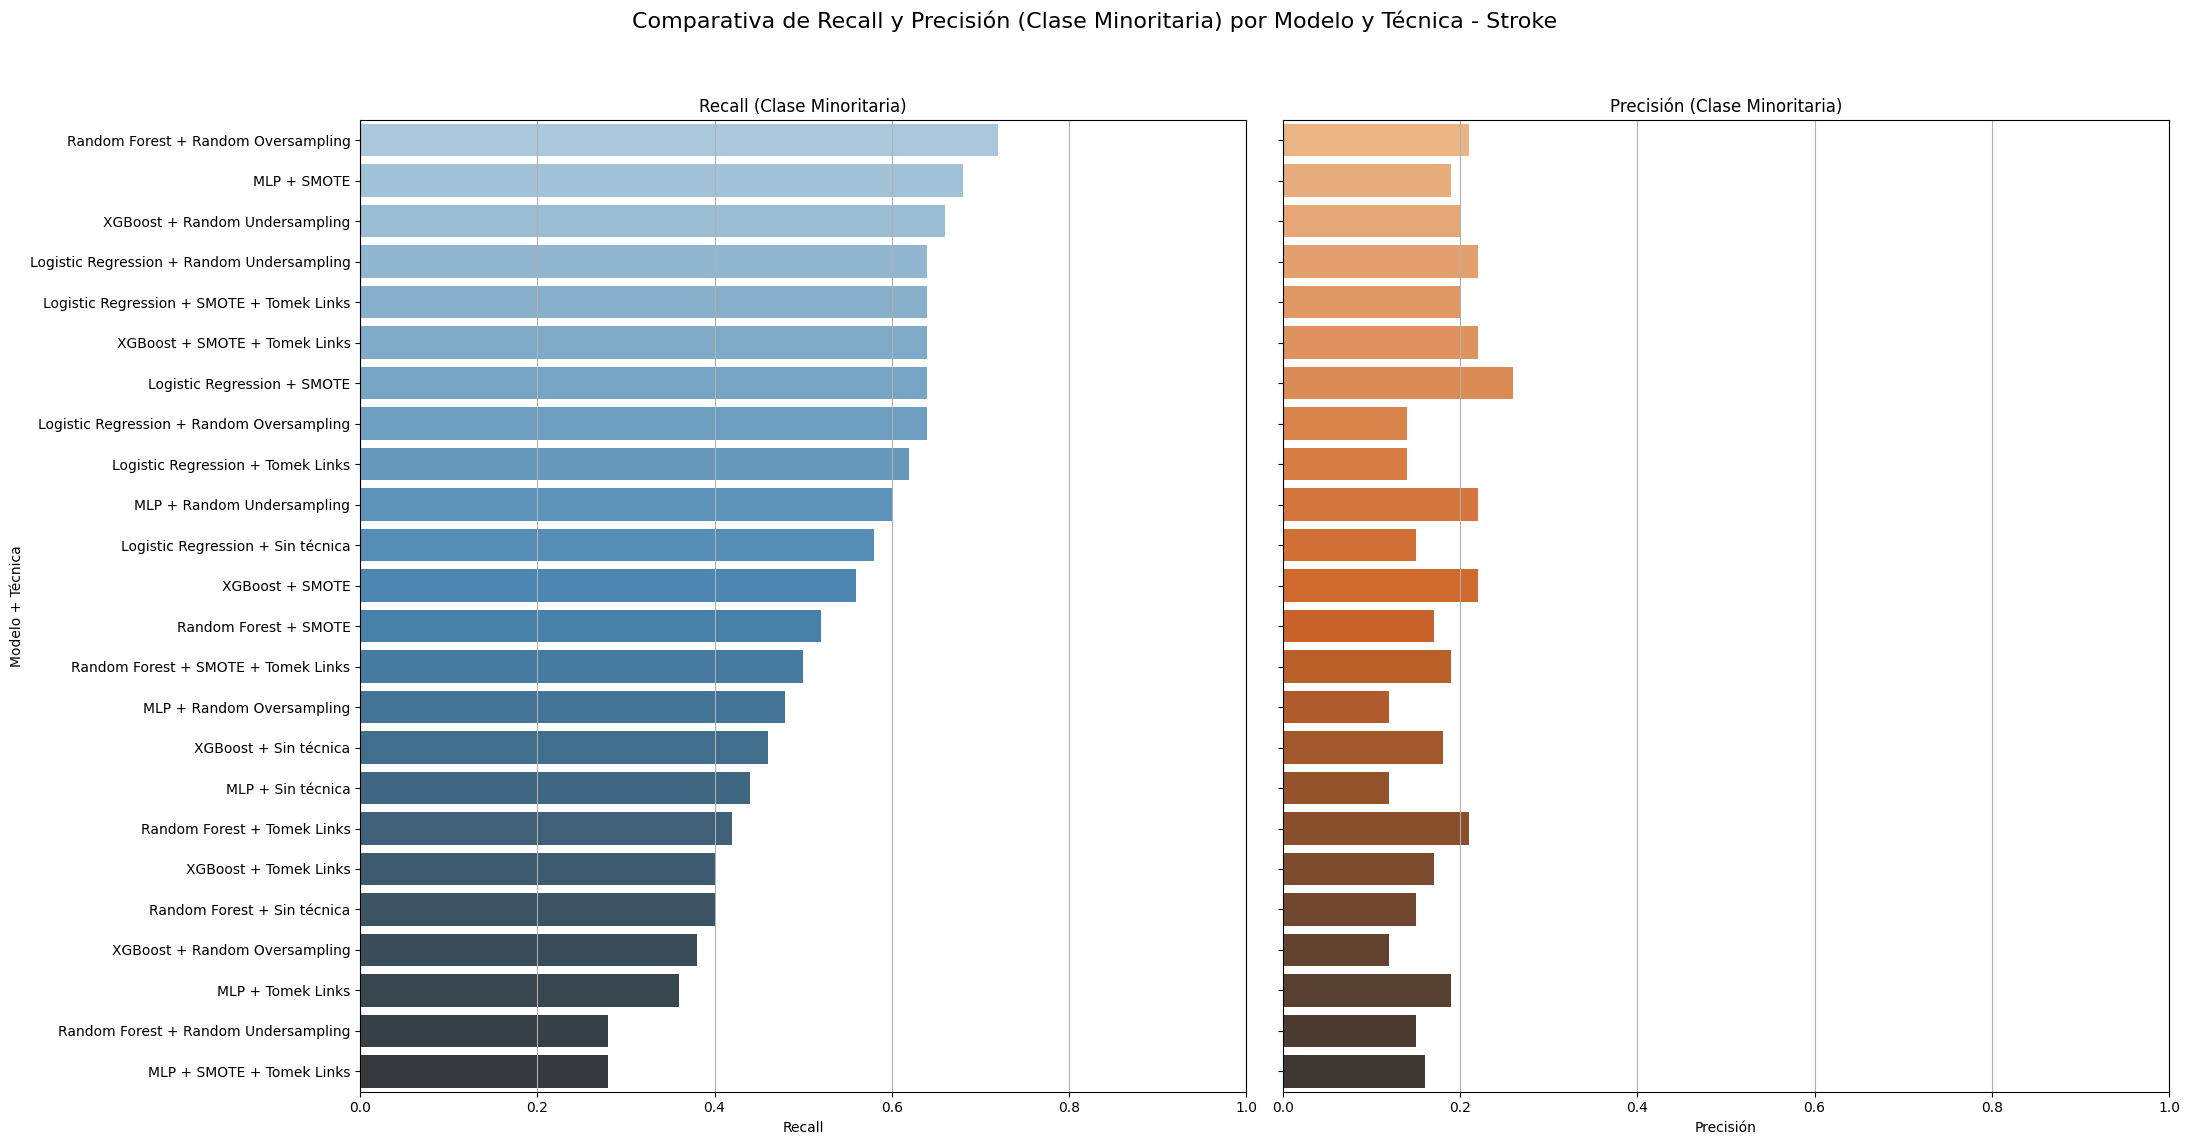

In [ ]:
stroke_data = [
    ("Stroke", "Logistic Regression", "Random Undersampling", 0.21, 0.64),
    ("Stroke", "Logistic Regression", "Random Oversampling", 0.19, 0.64),
    ("Stroke", "Logistic Regression", "SMOTE", 0.20, 0.64),
    ("Stroke", "Logistic Regression", "Tomek Links", 0.22, 0.62),
    ("Stroke", "Logistic Regression", "SMOTE + Tomek Links", 0.20, 0.64),
    ("Stroke", "Logistic Regression", "Sin técnica", 0.22, 0.58),
    ("Stroke", "Random Forest", "Random Undersampling", 0.26, 0.28),
    ("Stroke", "Random Forest", "Random Oversampling", 0.14, 0.72),
    ("Stroke", "Random Forest", "SMOTE", 0.14, 0.52),
    ("Stroke", "Random Forest", "Tomek Links", 0.22, 0.42),
    ("Stroke", "Random Forest", "SMOTE + Tomek Links", 0.15, 0.50),
    ("Stroke", "Random Forest", "Sin técnica", 0.22, 0.40),
    ("Stroke", "XGBoost", "Random Undersampling", 0.17, 0.66),
    ("Stroke", "XGBoost", "Random Oversampling", 0.19, 0.38),
    ("Stroke", "XGBoost", "SMOTE", 0.12, 0.56),
    ("Stroke", "XGBoost", "Tomek Links", 0.18, 0.40),
    ("Stroke", "XGBoost", "SMOTE + Tomek Links", 0.12, 0.64),
    ("Stroke", "XGBoost", "Sin técnica", 0.21, 0.46),
    ("Stroke", "MLP", "Random Undersampling", 0.17, 0.60),
    ("Stroke", "MLP", "Random Oversampling", 0.15, 0.48),
    ("Stroke", "MLP", "SMOTE", 0.12, 0.68),
    ("Stroke", "MLP", "Tomek Links", 0.19, 0.36),
    ("Stroke", "MLP", "SMOTE + Tomek Links", 0.15, 0.28),
    ("Stroke", "MLP", "Sin técnica", 0.16, 0.44)
]


fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)
df_stroke = pd.DataFrame(stroke_data, columns=["Dataset", "Modelo", "Técnica", "Precisión Min", "Recall Min"])
df_sorted_recall = df_stroke.sort_values(by="Recall Min", ascending=False)
df_sorted_precision = df_stroke.set_index(df_sorted_recall.index)

sns.barplot(data=df_sorted_recall, x="Recall Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
            palette="Blues_d", ax=axes[0])
axes[0].set_title("Recall (Clase Minoritaria)")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Modelo + Técnica")
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x')

sns.barplot(data=df_sorted_precision, x="Precisión Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
            palette="Oranges_d", ax=axes[1])
axes[1].set_title("Precisión (Clase Minoritaria)")
axes[1].set_xlabel("Precisión")
axes[1].set_ylabel("")
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x')

plt.suptitle("Comparativa de Recall y Precisión (Clase Minoritaria) por Modelo y Técnica - Stroke", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("stroke_naranja.png", dpi=300, bbox_inches='tight')
plt.show()



# Recall-Precision Heart Clase Minoritaria

<ipython-input-5-4236570440>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_recall, x="Recall Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
<ipython-input-5-4236570440>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_precision, x="Precisión Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],


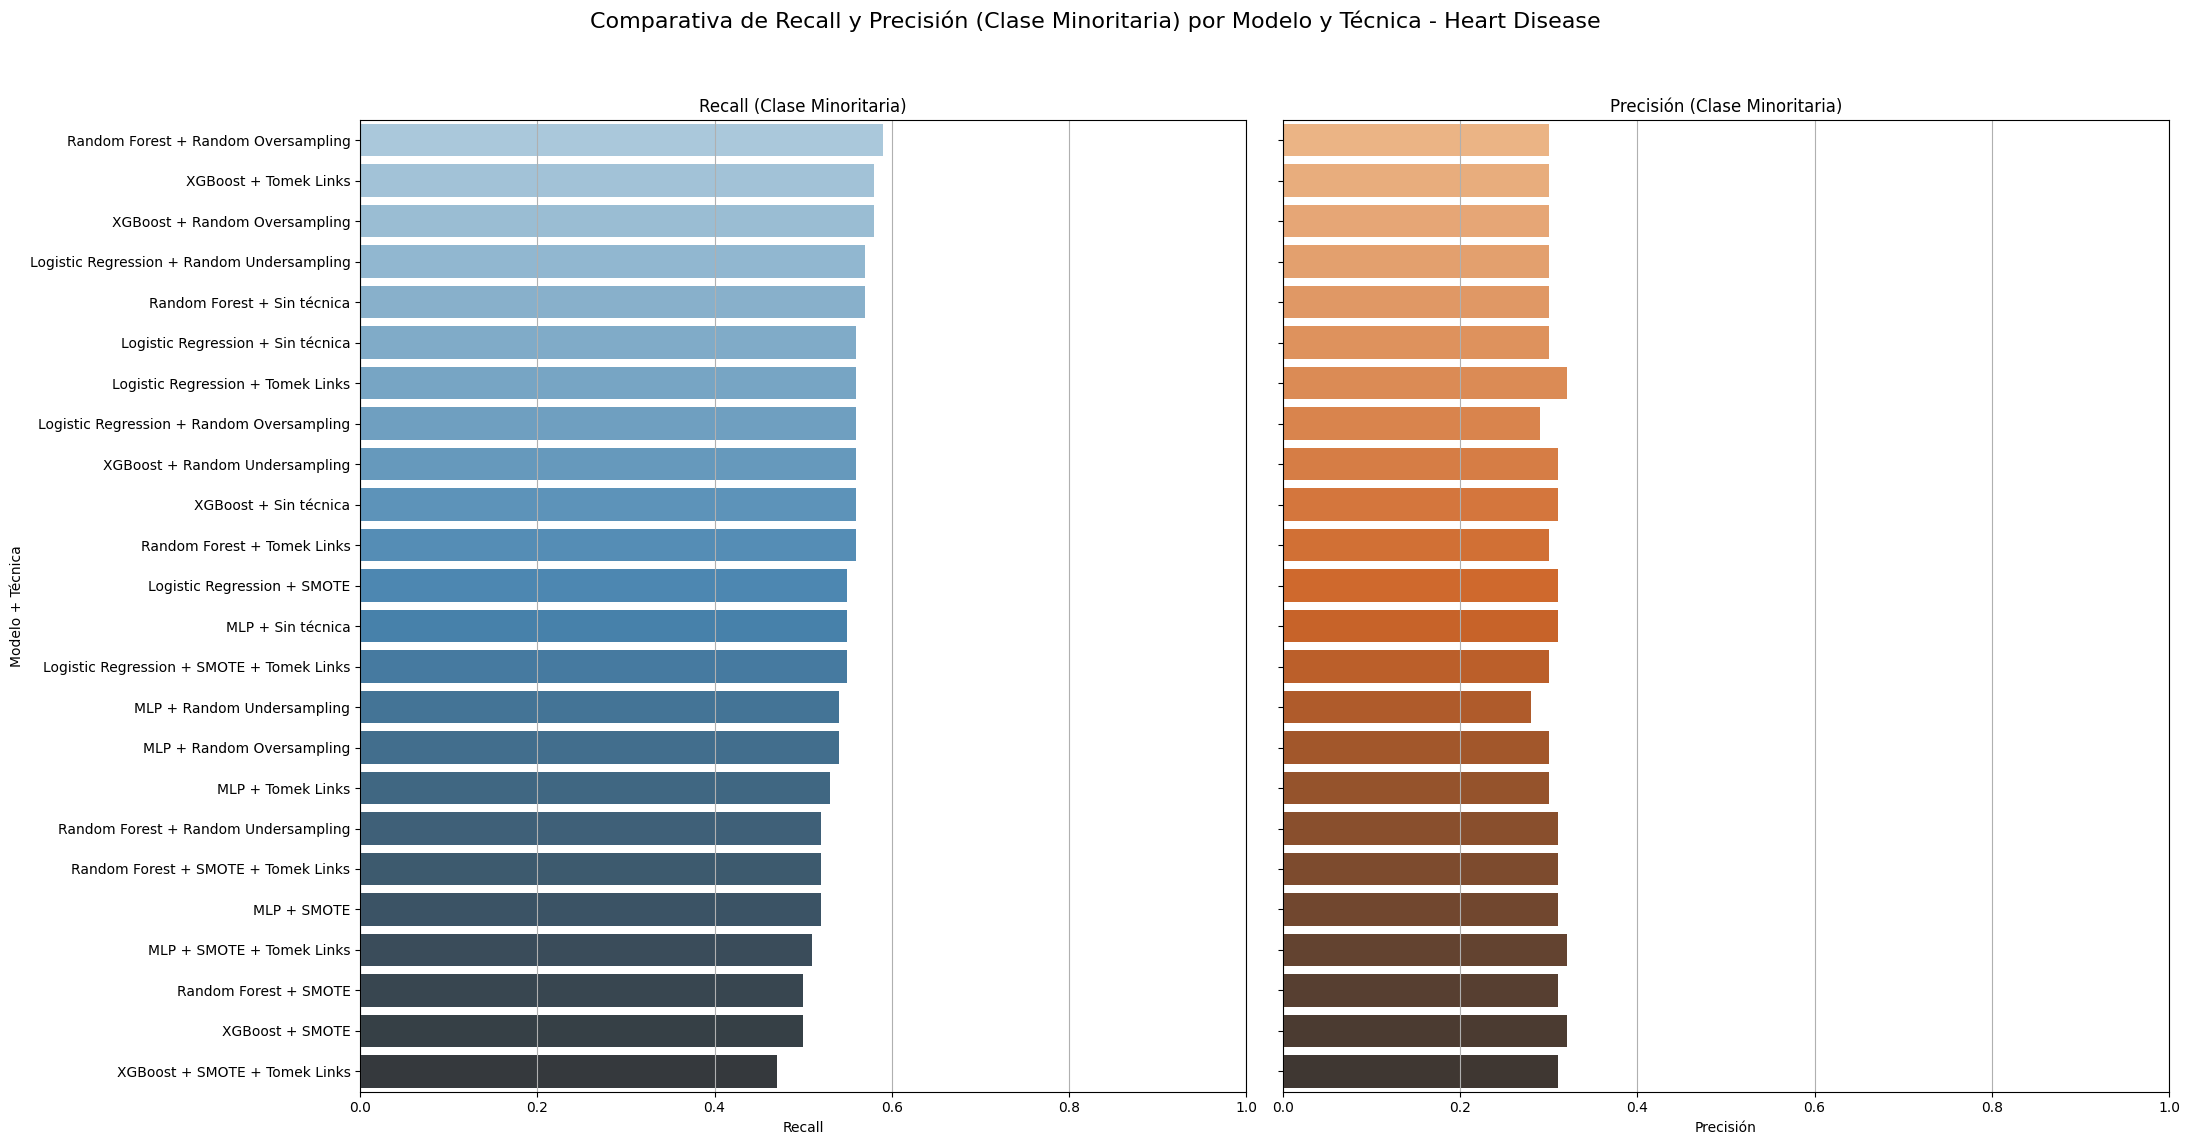

In [ ]:
heart_data = [
    ("Heart Disease", "Logistic Regression", "Random Undersampling", 0.30, 0.57),
    ("Heart Disease", "Logistic Regression", "Random Oversampling", 0.30, 0.56),
    ("Heart Disease", "Logistic Regression", "SMOTE", 0.30, 0.55),
    ("Heart Disease", "Logistic Regression", "Tomek Links", 0.30, 0.56),
    ("Heart Disease", "Logistic Regression", "SMOTE + Tomek Links", 0.30, 0.55),
    ("Heart Disease", "Logistic Regression", "Sin técnica", 0.30, 0.56),
    ("Heart Disease", "Random Forest", "Random Undersampling", 0.32, 0.52),
    ("Heart Disease", "Random Forest", "Random Oversampling", 0.29, 0.59),
    ("Heart Disease", "Random Forest", "SMOTE", 0.31, 0.50),
    ("Heart Disease", "Random Forest", "Tomek Links", 0.31, 0.56),
    ("Heart Disease", "Random Forest", "SMOTE + Tomek Links", 0.30, 0.52),
    ("Heart Disease", "Random Forest", "Sin técnica", 0.31, 0.57),
    ("Heart Disease", "XGBoost", "Random Undersampling", 0.31, 0.56),
    ("Heart Disease", "XGBoost", "Random Oversampling", 0.30, 0.58),
    ("Heart Disease", "XGBoost", "SMOTE", 0.28, 0.50),
    ("Heart Disease", "XGBoost", "Tomek Links", 0.30, 0.58),
    ("Heart Disease", "XGBoost", "SMOTE + Tomek Links", 0.30, 0.47),
    ("Heart Disease", "XGBoost", "Sin técnica", 0.31, 0.56),
    ("Heart Disease", "MLP", "Random Undersampling", 0.31, 0.54),
    ("Heart Disease", "MLP", "Random Oversampling", 0.31, 0.54),
    ("Heart Disease", "MLP", "SMOTE", 0.32, 0.52),
    ("Heart Disease", "MLP", "Tomek Links", 0.31, 0.53),
    ("Heart Disease", "MLP", "SMOTE + Tomek Links", 0.32, 0.51),
    ("Heart Disease", "MLP", "Sin técnica", 0.31, 0.55)
]


df_heart = pd.DataFrame(heart_data, columns=["Dataset", "Modelo", "Técnica", "Precisión Min", "Recall Min"])

fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)

df_sorted_recall = df_heart.sort_values(by="Recall Min", ascending=False)
df_sorted_precision = df_heart.set_index(df_sorted_recall.index)

sns.barplot(data=df_sorted_recall, x="Recall Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
            palette="Blues_d", ax=axes[0])
axes[0].set_title("Recall (Clase Minoritaria)")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Modelo + Técnica")
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x')

sns.barplot(data=df_sorted_precision, x="Precisión Min", y=df_sorted_recall["Modelo"] + " + " + df_sorted_recall["Técnica"],
            palette="Oranges_d", ax=axes[1])
axes[1].set_title("Precisión (Clase Minoritaria)")
axes[1].set_xlabel("Precisión")
axes[1].set_ylabel("")
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x')

plt.suptitle("Comparativa de Recall y Precisión (Clase Minoritaria) por Modelo y Técnica - Heart Disease", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("heart_naranja.png", dpi=300, bbox_inches='tight')
plt.show()


# Recall-Precision Heart-Stroke Clase Mayoritaria

In [ ]:

stroke_data_may = [
    ("Stroke", "Logistic Regression", "Random Undersampling", 0.98, 0.92),
    ("Stroke", "Logistic Regression", "Random Oversampling", 0.97, 0.94),
    ("Stroke", "Logistic Regression", "SMOTE", 0.98, 0.94),
    ("Stroke", "Logistic Regression", "Tomek Links", 0.97, 0.96),
    ("Stroke", "Logistic Regression", "SMOTE + Tomek Links", 0.98, 0.94),
    ("Stroke", "Logistic Regression", "Sin técnica", 0.97, 0.96),
    ("Stroke", "Random Forest", "Random Undersampling", 0.98, 0.90),
    ("Stroke", "Random Forest", "Random Oversampling", 0.98, 0.82),
    ("Stroke", "Random Forest", "SMOTE", 0.97, 0.90),
    ("Stroke", "Random Forest", "Tomek Links", 0.98, 0.88),
    ("Stroke", "Random Forest", "SMOTE + Tomek Links", 0.98, 0.83),
    ("Stroke", "Random Forest", "Sin técnica", 0.98, 0.89),
    ("Stroke", "XGBoost", "Random Undersampling", 0.98, 0.93),
    ("Stroke", "XGBoost", "Random Oversampling", 0.97, 0.96),
    ("Stroke", "XGBoost", "SMOTE", 0.97, 0.84),
    ("Stroke", "XGBoost", "Tomek Links", 0.98, 0.93),
    ("Stroke", "XGBoost", "SMOTE + Tomek Links", 0.98, 0.85),
    ("Stroke", "XGBoost", "Sin técnica", 0.97, 0.94),
    ("Stroke", "MLP", "Random Undersampling", 0.98, 0.85),
    ("Stroke", "MLP", "Random Oversampling", 0.97, 0.86),
    ("Stroke", "MLP", "SMOTE", 0.98, 0.75),
    ("Stroke", "MLP", "Tomek Links", 0.97, 0.92),
    ("Stroke", "MLP", "SMOTE + Tomek Links", 0.96, 0.92),
    ("Stroke", "MLP", "Sin técnica", 0.97, 0.88)
]


heart_data_may = [
    ("Heart Disease", "Logistic Regression", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Random Oversampling", 0.95, 0.90),
    ("Heart Disease", "Logistic Regression", "SMOTE", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "SMOTE + Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Sin técnica", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "Random Oversampling", 0.95, 0.88),
    ("Heart Disease", "Random Forest", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "Random Forest", "Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "SMOTE + Tomek Links", 0.95, 0.90),
    ("Heart Disease", "Random Forest", "Sin técnica", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "Random Oversampling", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "XGBoost", "Tomek Links", 0.96, 0.88),
    ("Heart Disease", "XGBoost", "SMOTE + Tomek Links", 0.95, 0.88),
    ("Heart Disease", "XGBoost", "Sin técnica", 0.95, 0.91),
    ("Heart Disease", "MLP", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "MLP", "Random Oversampling", 0.95, 0.89),
    ("Heart Disease", "MLP", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "MLP", "Tomek Links", 0.95, 0.90),
    ("Heart Disease", "MLP", "SMOTE + Tomek Links", 0.95, 0.90),
    ("Heart Disease", "MLP", "Sin técnica", 0.95, 0.89)
]


df_stroke_may = pd.DataFrame(stroke_data_may, columns=["Dataset", "Modelo", "Técnica", "Precisión May", "Recall May"])
df_heart_may = pd.DataFrame(heart_data_may, columns=["Dataset", "Modelo", "Técnica", "Precisión May", "Recall May"])


<ipython-input-7-539006330>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stroke_may_sorted, x="Recall May", y=df_stroke_may_sorted["Modelo"] + " + " + df_stroke_may_sorted["Técnica"],
<ipython-input-7-539006330>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_stroke_may_sorted, x="Precisión May", y=df_stroke_may_sorted["Modelo"] + " + " + df_stroke_may_sorted["Técnica"],


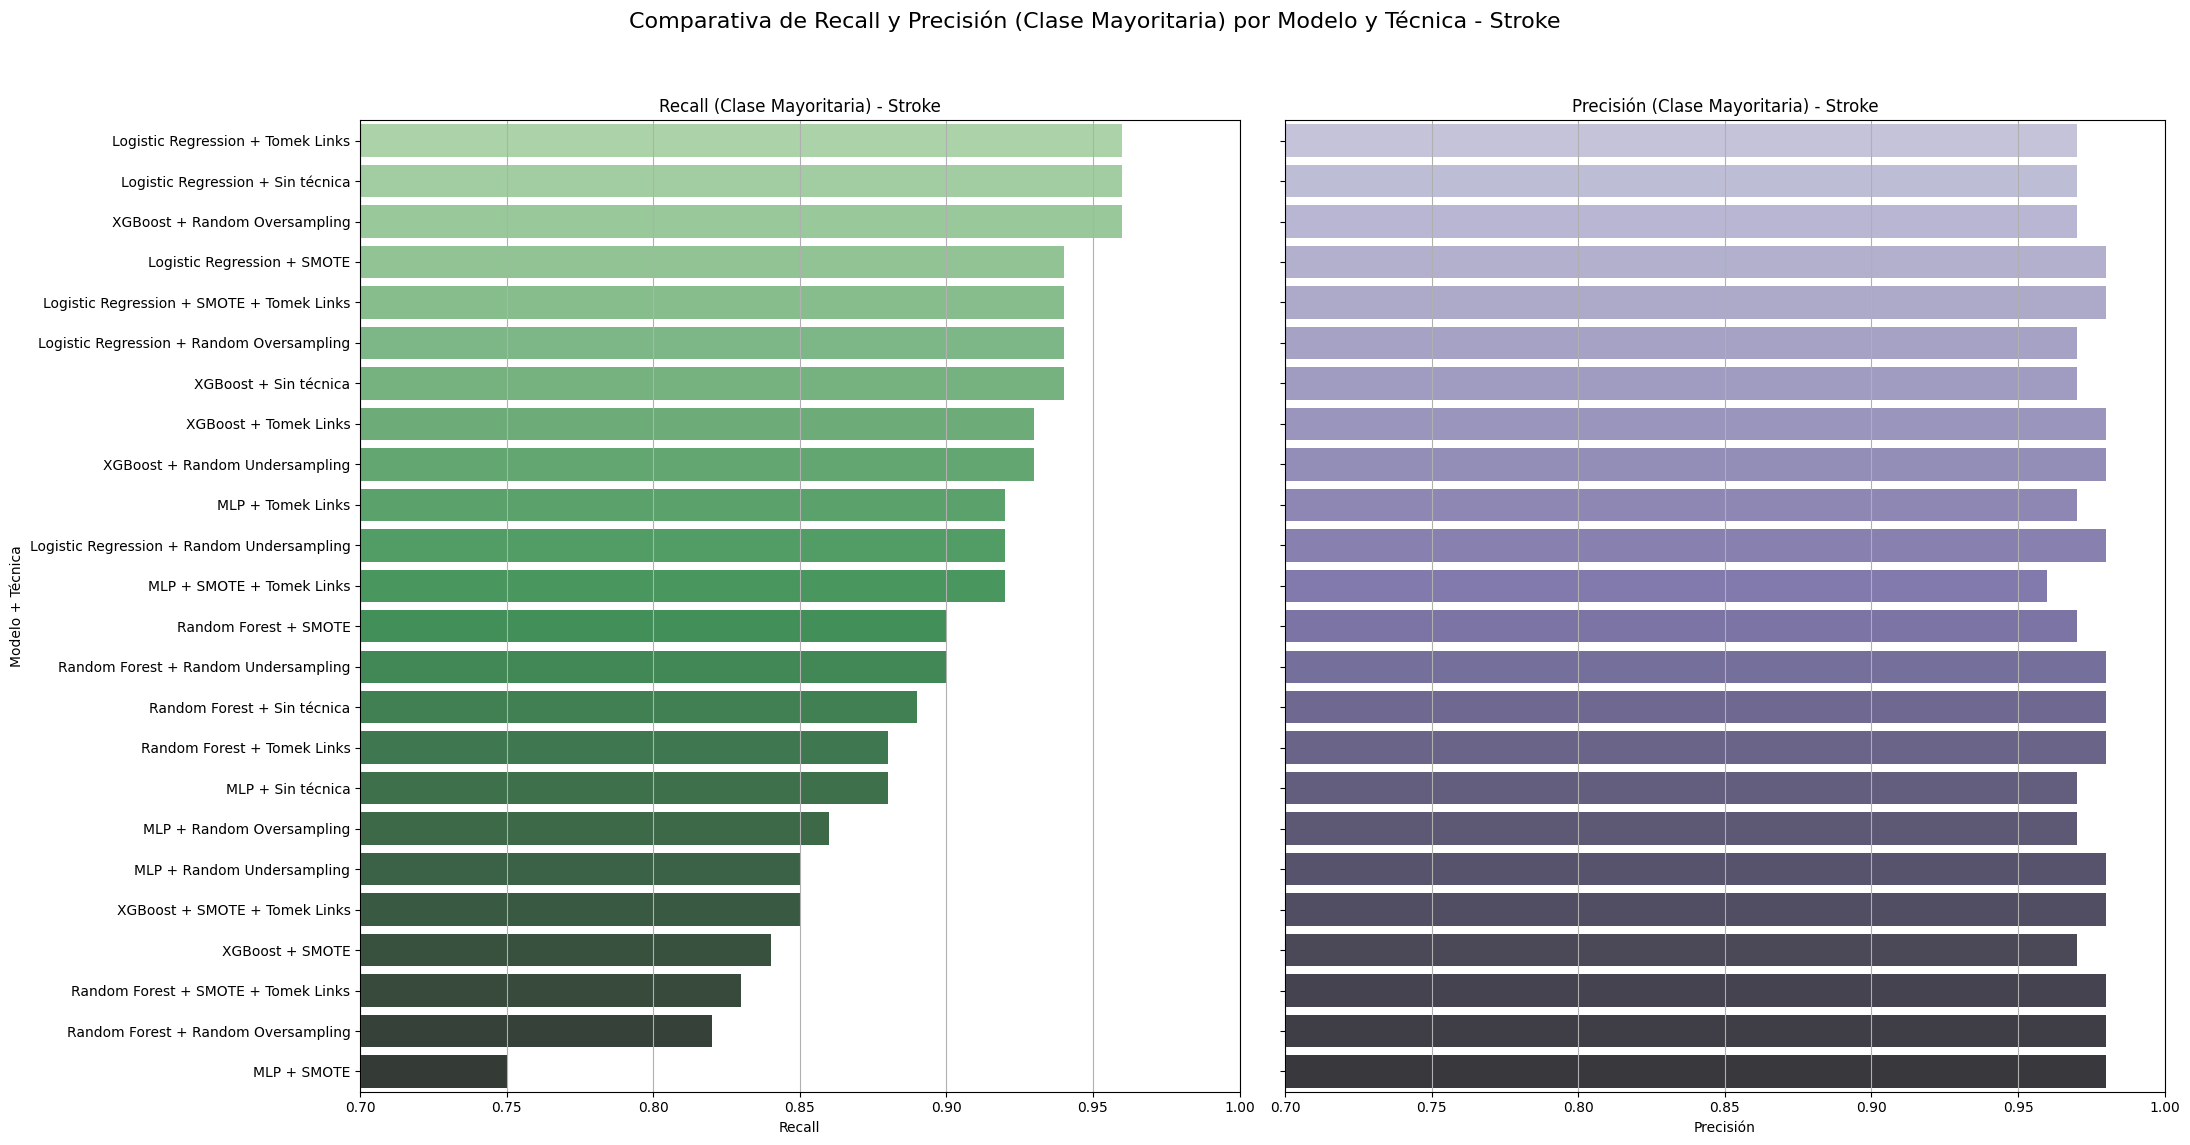

In [ ]:
df_stroke_may_sorted = df_stroke_may.sort_values(by="Recall May", ascending=False)
df_heart_may_sorted = df_heart_may.sort_values(by="Recall May", ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)


sns.barplot(data=df_stroke_may_sorted, x="Recall May", y=df_stroke_may_sorted["Modelo"] + " + " + df_stroke_may_sorted["Técnica"],
            palette="Greens_d", ax=axes[0])
axes[0].set_title("Recall (Clase Mayoritaria) - Stroke")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Modelo + Técnica")
axes[0].set_xlim(0.7, 1)
axes[0].grid(axis='x')


sns.barplot(data=df_stroke_may_sorted, x="Precisión May", y=df_stroke_may_sorted["Modelo"] + " + " + df_stroke_may_sorted["Técnica"],
            palette="Purples_d", ax=axes[1])
axes[1].set_title("Precisión (Clase Mayoritaria) - Stroke")
axes[1].set_xlabel("Precisión")
axes[1].set_ylabel("")
axes[1].set_xlim(0.7, 1)
axes[1].grid(axis='x')

plt.suptitle("Comparativa de Recall y Precisión (Clase Mayoritaria) por Modelo y Técnica - Stroke", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("stroke_verde.png", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-8-424546977>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_heart_may_sorted, x="Recall May", y=df_heart_may_sorted["Modelo"] + " + " + df_heart_may_sorted["Técnica"],
<ipython-input-8-424546977>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_heart_may_sorted, x="Precisión May", y=df_heart_may_sorted["Modelo"] + " + " + df_heart_may_sorted["Técnica"],


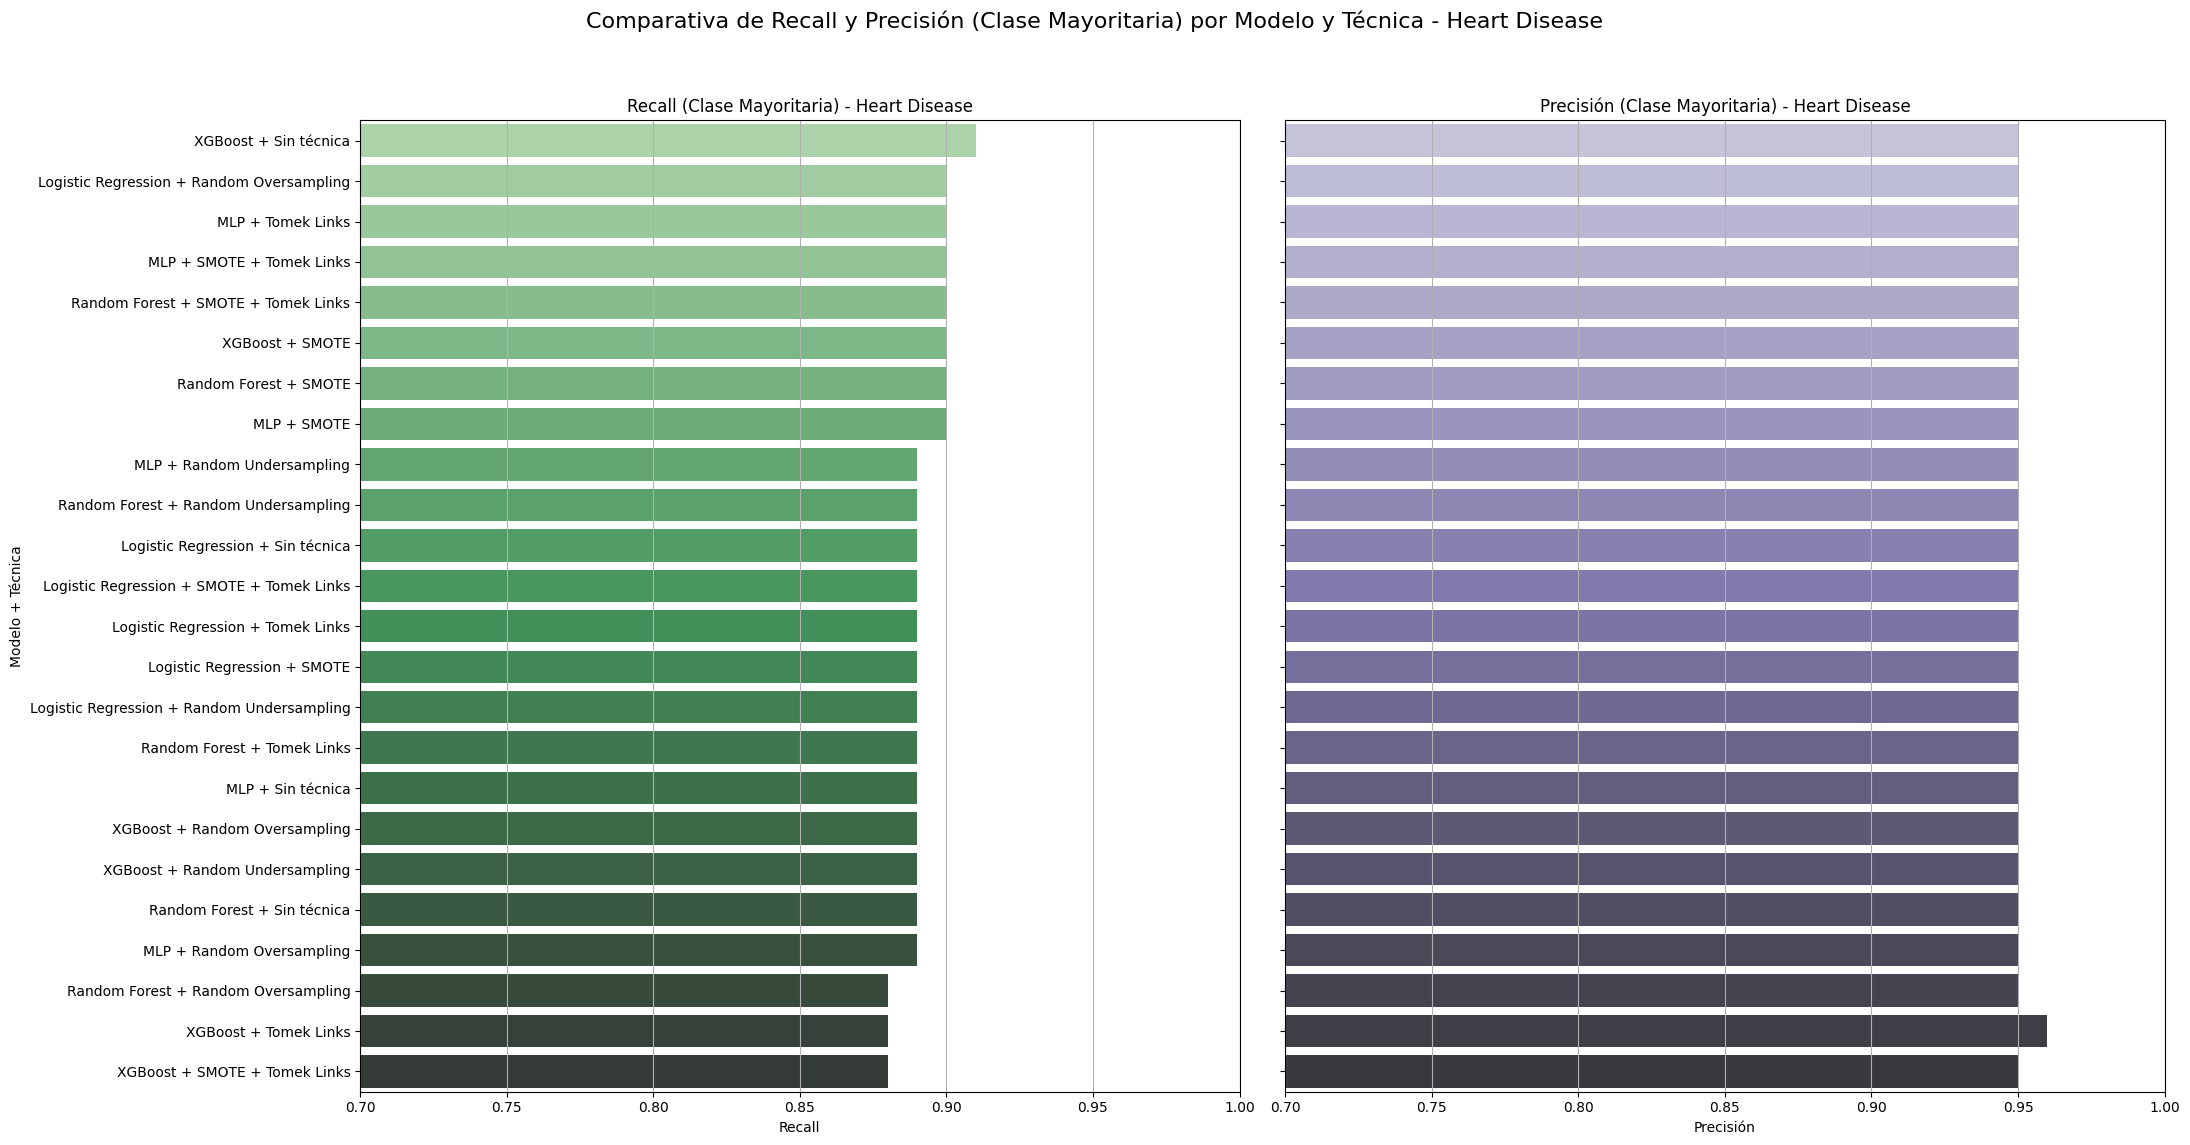

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)


sns.barplot(data=df_heart_may_sorted, x="Recall May", y=df_heart_may_sorted["Modelo"] + " + " + df_heart_may_sorted["Técnica"],
            palette="Greens_d", ax=axes[0])
axes[0].set_title("Recall (Clase Mayoritaria) - Heart Disease")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Modelo + Técnica")
axes[0].set_xlim(0.7, 1)
axes[0].grid(axis='x')


sns.barplot(data=df_heart_may_sorted, x="Precisión May", y=df_heart_may_sorted["Modelo"] + " + " + df_heart_may_sorted["Técnica"],
            palette="Purples_d", ax=axes[1])
axes[1].set_title("Precisión (Clase Mayoritaria) - Heart Disease")
axes[1].set_xlabel("Precisión")
axes[1].set_ylabel("")
axes[1].set_xlim(0.7, 1)
axes[1].grid(axis='x')

plt.suptitle("Comparativa de Recall y Precisión (Clase Mayoritaria) por Modelo y Técnica - Heart Disease", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("heart_verde.png", dpi=300, bbox_inches='tight')
plt.show()

# F1-Score Stroke Clase Minoritaria

/tmp/ipython-input-11-3287103184.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_f1, x="F1-Score", y="Modelo + Técnica", palette="viridis")


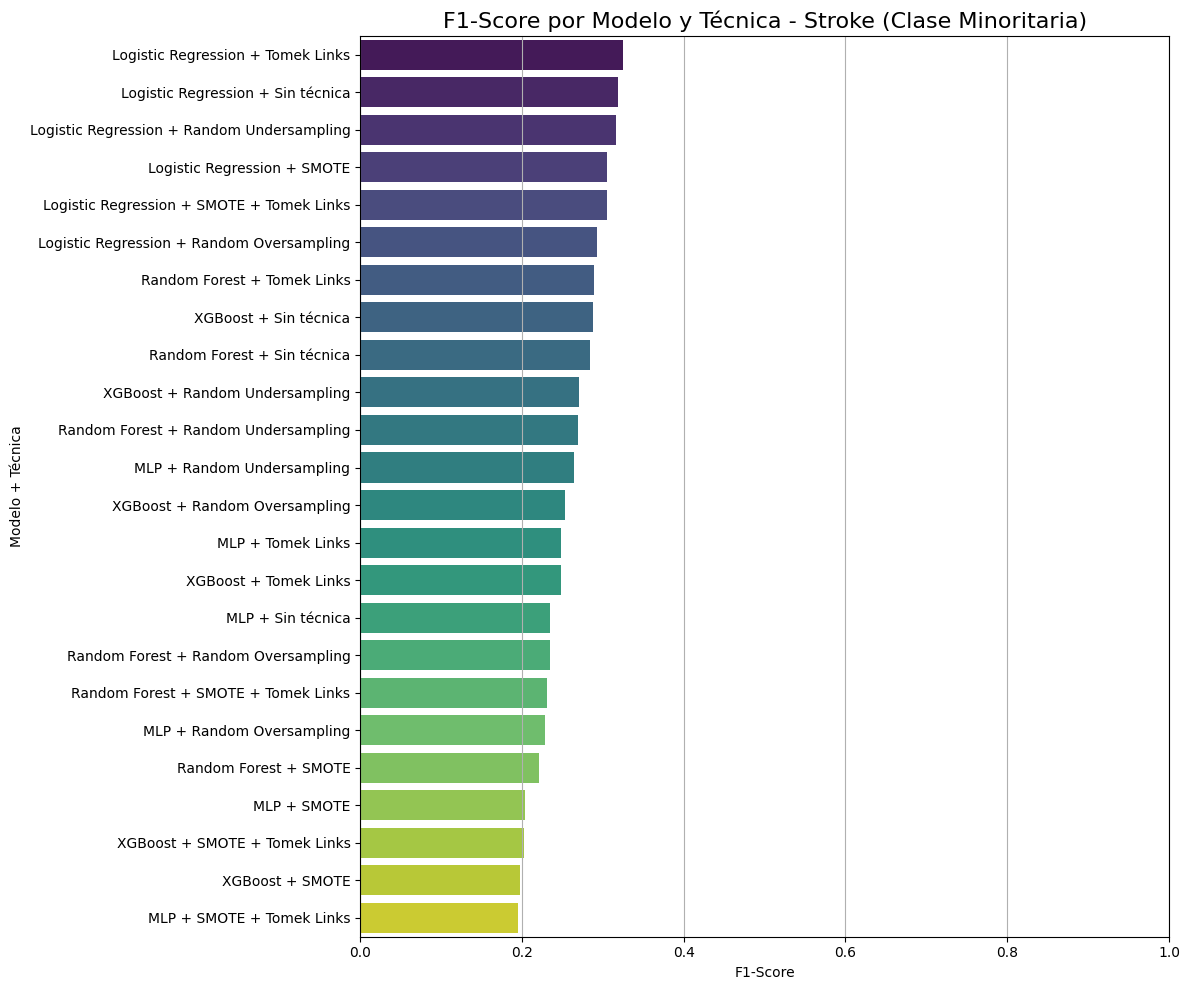

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


stroke_data = [
    ("Stroke", "Logistic Regression", "Random Undersampling", 0.21, 0.64),
    ("Stroke", "Logistic Regression", "Random Oversampling", 0.19, 0.64),
    ("Stroke", "Logistic Regression", "SMOTE", 0.20, 0.64),
    ("Stroke", "Logistic Regression", "Tomek Links", 0.22, 0.62),
    ("Stroke", "Logistic Regression", "SMOTE + Tomek Links", 0.20, 0.64),
    ("Stroke", "Logistic Regression", "Sin técnica", 0.22, 0.58),
    ("Stroke", "Random Forest", "Random Undersampling", 0.26, 0.28),
    ("Stroke", "Random Forest", "Random Oversampling", 0.14, 0.72),
    ("Stroke", "Random Forest", "SMOTE", 0.14, 0.52),
    ("Stroke", "Random Forest", "Tomek Links", 0.22, 0.42),
    ("Stroke", "Random Forest", "SMOTE + Tomek Links", 0.15, 0.50),
    ("Stroke", "Random Forest", "Sin técnica", 0.22, 0.40),
    ("Stroke", "XGBoost", "Random Undersampling", 0.17, 0.66),
    ("Stroke", "XGBoost", "Random Oversampling", 0.19, 0.38),
    ("Stroke", "XGBoost", "SMOTE", 0.12, 0.56),
    ("Stroke", "XGBoost", "Tomek Links", 0.18, 0.40),
    ("Stroke", "XGBoost", "SMOTE + Tomek Links", 0.12, 0.64),
    ("Stroke", "XGBoost", "Sin técnica", 0.21, 0.46),
    ("Stroke", "MLP", "Random Undersampling", 0.17, 0.60),
    ("Stroke", "MLP", "Random Oversampling", 0.15, 0.48),
    ("Stroke", "MLP", "SMOTE", 0.12, 0.68),
    ("Stroke", "MLP", "Tomek Links", 0.19, 0.36),
    ("Stroke", "MLP", "SMOTE + Tomek Links", 0.15, 0.28),
    ("Stroke", "MLP", "Sin técnica", 0.16, 0.44)
]


df = pd.DataFrame(stroke_data, columns=["Dataset", "Modelo", "Técnica", "Precisión Min", "Recall Min"])
df["F1-Score"] = 2 * (df["Precisión Min"] * df["Recall Min"]) / (df["Precisión Min"] + df["Recall Min"])
df["Modelo + Técnica"] = df["Modelo"] + " + " + df["Técnica"]
df_sorted_f1 = df.sort_values(by="F1-Score", ascending=False)


plt.figure(figsize=(12, 10))
sns.barplot(data=df_sorted_f1, x="F1-Score", y="Modelo + Técnica", palette="viridis")
plt.title("F1-Score por Modelo y Técnica - Stroke (Clase Minoritaria)", fontsize=16)
plt.xlabel("F1-Score")
plt.ylabel("Modelo + Técnica")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("f1_score_stroke_clase_minoritaria.png", dpi=300)
plt.show()


# F1-Score Heart Clase Minoritaria

/tmp/ipython-input-12-1488184973.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_f1_heart, x="F1-Score", y="Modelo + Técnica", palette="viridis")


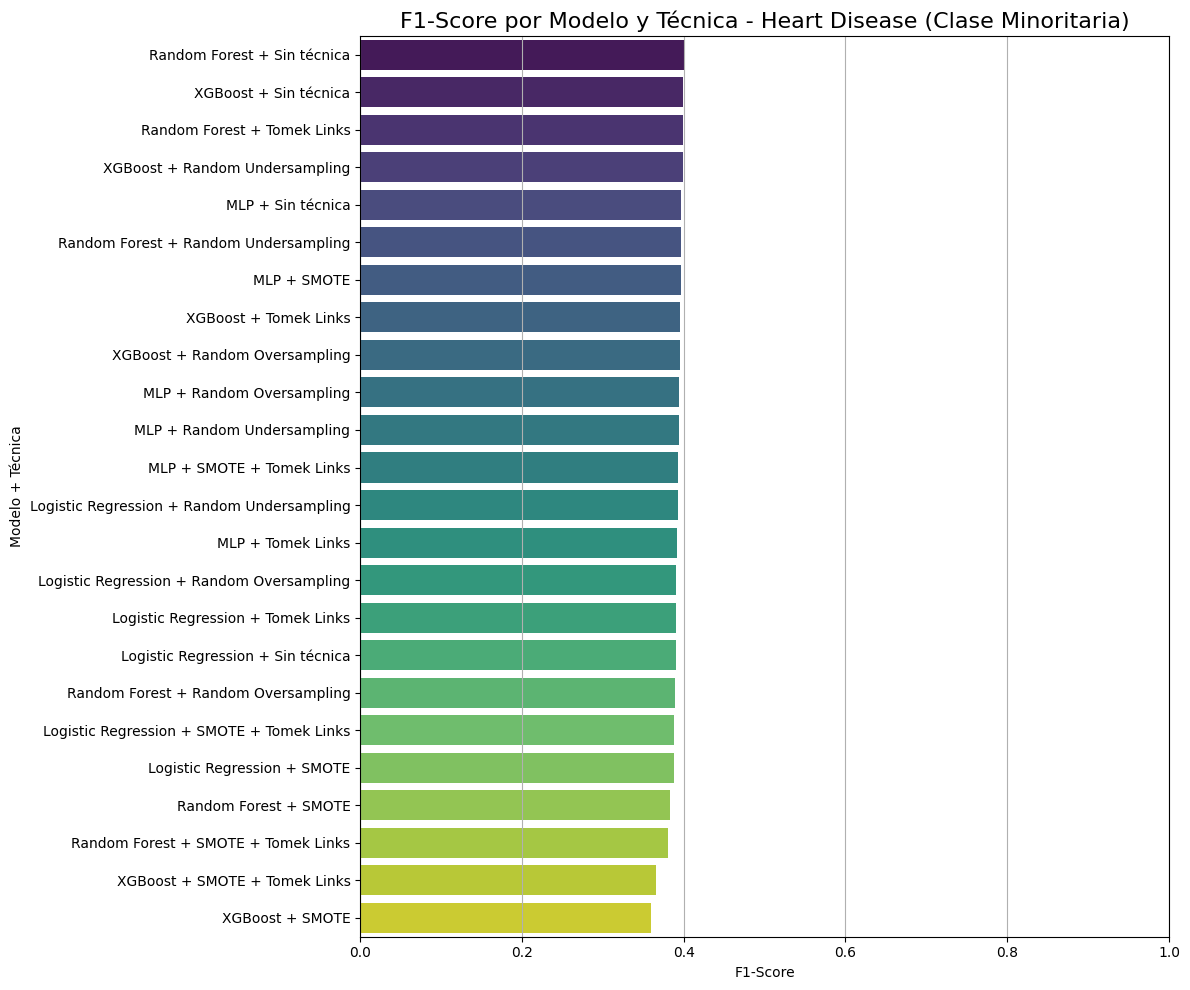

In [ ]:

heart_data = [
    ("Heart Disease", "Logistic Regression", "Random Undersampling", 0.30, 0.57),
    ("Heart Disease", "Logistic Regression", "Random Oversampling", 0.30, 0.56),
    ("Heart Disease", "Logistic Regression", "SMOTE", 0.30, 0.55),
    ("Heart Disease", "Logistic Regression", "Tomek Links", 0.30, 0.56),
    ("Heart Disease", "Logistic Regression", "SMOTE + Tomek Links", 0.30, 0.55),
    ("Heart Disease", "Logistic Regression", "Sin técnica", 0.30, 0.56),
    ("Heart Disease", "Random Forest", "Random Undersampling", 0.32, 0.52),
    ("Heart Disease", "Random Forest", "Random Oversampling", 0.29, 0.59),
    ("Heart Disease", "Random Forest", "SMOTE", 0.31, 0.50),
    ("Heart Disease", "Random Forest", "Tomek Links", 0.31, 0.56),
    ("Heart Disease", "Random Forest", "SMOTE + Tomek Links", 0.30, 0.52),
    ("Heart Disease", "Random Forest", "Sin técnica", 0.31, 0.57),
    ("Heart Disease", "XGBoost", "Random Undersampling", 0.31, 0.56),
    ("Heart Disease", "XGBoost", "Random Oversampling", 0.30, 0.58),
    ("Heart Disease", "XGBoost", "SMOTE", 0.28, 0.50),
    ("Heart Disease", "XGBoost", "Tomek Links", 0.30, 0.58),
    ("Heart Disease", "XGBoost", "SMOTE + Tomek Links", 0.30, 0.47),
    ("Heart Disease", "XGBoost", "Sin técnica", 0.31, 0.56),
    ("Heart Disease", "MLP", "Random Undersampling", 0.31, 0.54),
    ("Heart Disease", "MLP", "Random Oversampling", 0.31, 0.54),
    ("Heart Disease", "MLP", "SMOTE", 0.32, 0.52),
    ("Heart Disease", "MLP", "Tomek Links", 0.31, 0.53),
    ("Heart Disease", "MLP", "SMOTE + Tomek Links", 0.32, 0.51),
    ("Heart Disease", "MLP", "Sin técnica", 0.31, 0.55)
]


df_heart = pd.DataFrame(heart_data, columns=["Dataset", "Modelo", "Técnica", "Precisión Min", "Recall Min"])
df_heart["F1-Score"] = 2 * (df_heart["Precisión Min"] * df_heart["Recall Min"]) / (df_heart["Precisión Min"] + df_heart["Recall Min"])
df_heart["Modelo + Técnica"] = df_heart["Modelo"] + " + " + df_heart["Técnica"]
df_sorted_f1_heart = df_heart.sort_values(by="F1-Score", ascending=False)


plt.figure(figsize=(12, 10))
sns.barplot(data=df_sorted_f1_heart, x="F1-Score", y="Modelo + Técnica", palette="viridis")
plt.title("F1-Score por Modelo y Técnica - Heart Disease (Clase Minoritaria)", fontsize=16)
plt.xlabel("F1-Score")
plt.ylabel("Modelo + Técnica")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("f1_score_heart_clase_minoritaria.png", dpi=300)
plt.show()


# F1-Score Stroke Clase Mayoritaria

/tmp/ipython-input-13-1890285695.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_stroke_may, x="F1-Score", y="Modelo + Técnica", palette="viridis")


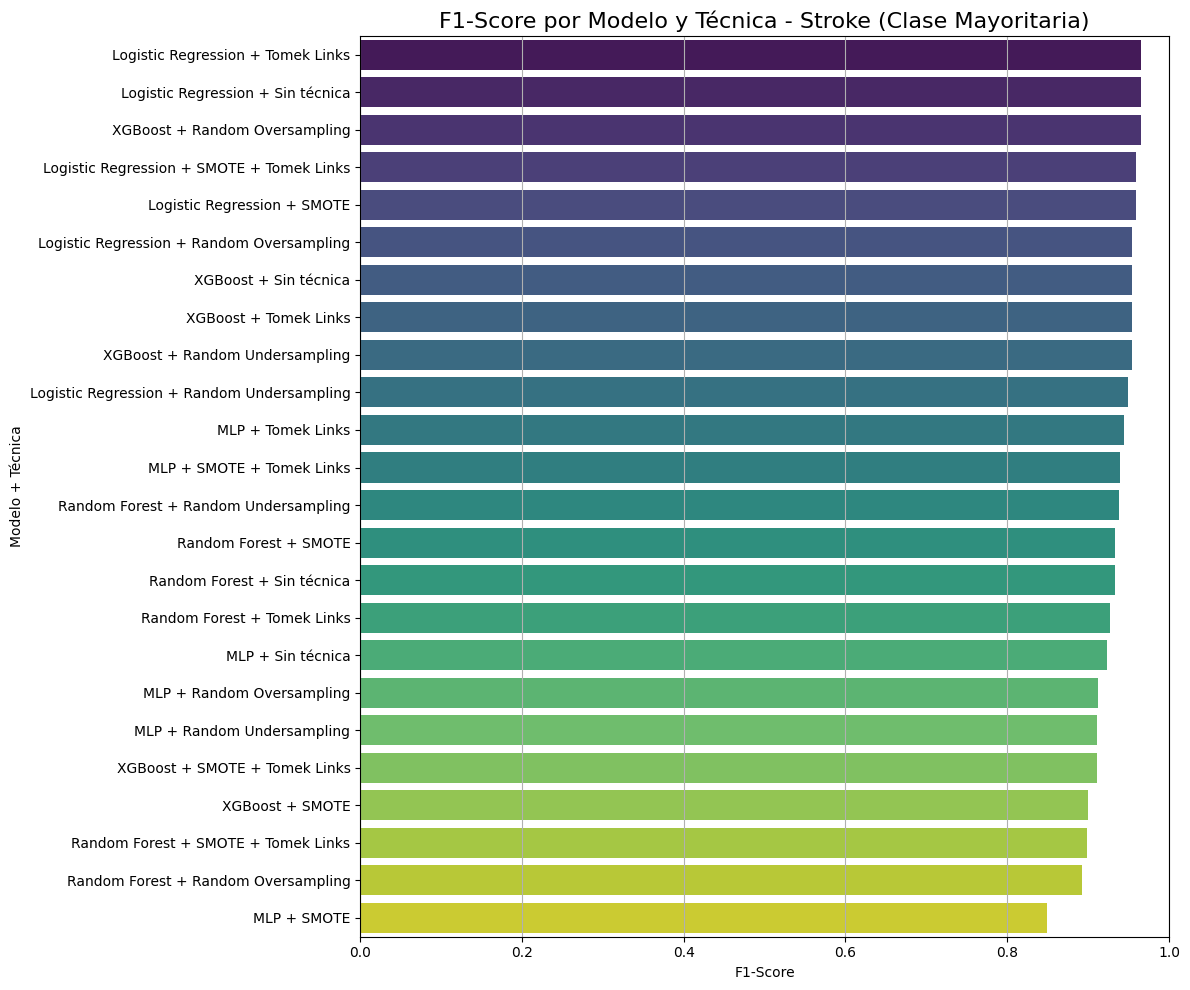

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stroke_data_may = [
    ("Stroke", "Logistic Regression", "Random Undersampling", 0.98, 0.92),
    ("Stroke", "Logistic Regression", "Random Oversampling", 0.97, 0.94),
    ("Stroke", "Logistic Regression", "SMOTE", 0.98, 0.94),
    ("Stroke", "Logistic Regression", "Tomek Links", 0.97, 0.96),
    ("Stroke", "Logistic Regression", "SMOTE + Tomek Links", 0.98, 0.94),
    ("Stroke", "Logistic Regression", "Sin técnica", 0.97, 0.96),
    ("Stroke", "Random Forest", "Random Undersampling", 0.98, 0.90),
    ("Stroke", "Random Forest", "Random Oversampling", 0.98, 0.82),
    ("Stroke", "Random Forest", "SMOTE", 0.97, 0.90),
    ("Stroke", "Random Forest", "Tomek Links", 0.98, 0.88),
    ("Stroke", "Random Forest", "SMOTE + Tomek Links", 0.98, 0.83),
    ("Stroke", "Random Forest", "Sin técnica", 0.98, 0.89),
    ("Stroke", "XGBoost", "Random Undersampling", 0.98, 0.93),
    ("Stroke", "XGBoost", "Random Oversampling", 0.97, 0.96),
    ("Stroke", "XGBoost", "SMOTE", 0.97, 0.84),
    ("Stroke", "XGBoost", "Tomek Links", 0.98, 0.93),
    ("Stroke", "XGBoost", "SMOTE + Tomek Links", 0.98, 0.85),
    ("Stroke", "XGBoost", "Sin técnica", 0.97, 0.94),
    ("Stroke", "MLP", "Random Undersampling", 0.98, 0.85),
    ("Stroke", "MLP", "Random Oversampling", 0.97, 0.86),
    ("Stroke", "MLP", "SMOTE", 0.98, 0.75),
    ("Stroke", "MLP", "Tomek Links", 0.97, 0.92),
    ("Stroke", "MLP", "SMOTE + Tomek Links", 0.96, 0.92),
    ("Stroke", "MLP", "Sin técnica", 0.97, 0.88)
]




df_stroke_may = pd.DataFrame(stroke_data_may, columns=["Dataset", "Modelo", "Técnica", "Precisión May", "Recall May"])



df_stroke_may["F1-Score"] = 2 * (df_stroke_may["Precisión May"] * df_stroke_may["Recall May"]) / (
    df_stroke_may["Precisión May"] + df_stroke_may["Recall May"]
)
df_stroke_may["Modelo + Técnica"] = df_stroke_may["Modelo"] + " + " + df_stroke_may["Técnica"]
df_sorted_stroke_may = df_stroke_may.sort_values(by="F1-Score", ascending=False)




plt.figure(figsize=(12, 10))
sns.barplot(data=df_sorted_stroke_may, x="F1-Score", y="Modelo + Técnica", palette="viridis")
plt.title("F1-Score por Modelo y Técnica - Stroke (Clase Mayoritaria)", fontsize=16)
plt.xlabel("F1-Score")
plt.ylabel("Modelo + Técnica")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("f1_score_stroke_clase_mayoritaria.png", dpi=300)
plt.show()




# F1-Score Heart Clase Mayoritaria

/tmp/ipython-input-14-2309948740.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted_heart_may, x="F1-Score", y="Modelo + Técnica", palette="viridis")


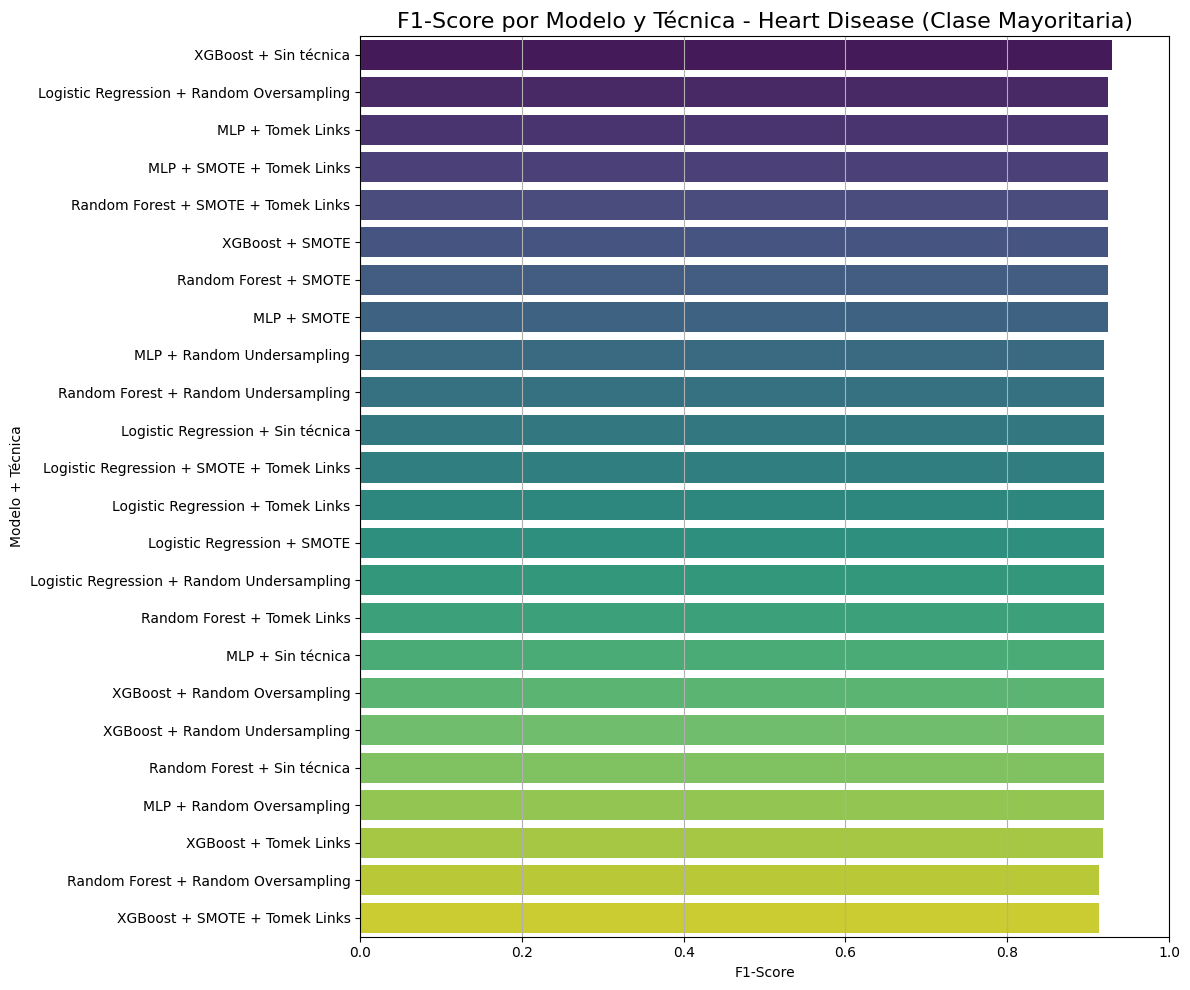

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heart_data_may = [
    ("Heart Disease", "Logistic Regression", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Random Oversampling", 0.95, 0.90),
    ("Heart Disease", "Logistic Regression", "SMOTE", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "SMOTE + Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Logistic Regression", "Sin técnica", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "Random Oversampling", 0.95, 0.88),
    ("Heart Disease", "Random Forest", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "Random Forest", "Tomek Links", 0.95, 0.89),
    ("Heart Disease", "Random Forest", "SMOTE + Tomek Links", 0.95, 0.90),
    ("Heart Disease", "Random Forest", "Sin técnica", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "Random Oversampling", 0.95, 0.89),
    ("Heart Disease", "XGBoost", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "XGBoost", "Tomek Links", 0.96, 0.88),
    ("Heart Disease", "XGBoost", "SMOTE + Tomek Links", 0.95, 0.88),
    ("Heart Disease", "XGBoost", "Sin técnica", 0.95, 0.91),
    ("Heart Disease", "MLP", "Random Undersampling", 0.95, 0.89),
    ("Heart Disease", "MLP", "Random Oversampling", 0.95, 0.89),
    ("Heart Disease", "MLP", "SMOTE", 0.95, 0.90),
    ("Heart Disease", "MLP", "Tomek Links", 0.95, 0.90),
    ("Heart Disease", "MLP", "SMOTE + Tomek Links", 0.95, 0.90),
    ("Heart Disease", "MLP", "Sin técnica", 0.95, 0.89)
]

df_heart_may = pd.DataFrame(heart_data_may, columns=["Dataset", "Modelo", "Técnica", "Precisión May", "Recall May"])
df_heart_may["F1-Score"] = 2 * (df_heart_may["Precisión May"] * df_heart_may["Recall May"]) / (
    df_heart_may["Precisión May"] + df_heart_may["Recall May"]
)
df_heart_may["Modelo + Técnica"] = df_heart_may["Modelo"] + " + " + df_heart_may["Técnica"]
df_sorted_heart_may = df_heart_may.sort_values(by="F1-Score", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(data=df_sorted_heart_may, x="F1-Score", y="Modelo + Técnica", palette="viridis")
plt.title("F1-Score por Modelo y Técnica - Heart Disease (Clase Mayoritaria)", fontsize=16)
plt.xlabel("F1-Score")
plt.ylabel("Modelo + Técnica")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("f1_score_heart_clase_mayoritaria.png", dpi=300)
plt.show()